In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
results_dir = 'results/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [5]:
os.listdir(results_dir)

['adultsDE',
 'adultsDE.zip',
 'adults_de.pkl',
 'annotation.csv',
 'annotation_adult.csv',
 'chimpDE',
 'chimp_de.pkl',
 'expression.csv',
 'expression_adult.csv',
 'humanDE',
 'human_de.pkl',
 'macaqueDE',
 'macaque_de.pkl',
 'markers_velmeshev.xlsx']

## Load files

### Load pseudobulk files

In [6]:
pb_dir_path = '../data/pseudobulks/'

In [7]:
os.listdir('../data/pseudobulks/')

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_age_sample_norm.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [8]:
adata_pb= sc.read_h5ad(pb_dir_path + 'pb_mammals.h5ad')
adata_pb = adata_pb[adata_pb.obs.sample_id != 'chimp_13302'].copy()
adata_pb

AnnData object with n_obs × n_vars = 89 × 14963
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    layers: 'psbulk_props'

In [9]:
sc.pp.normalize_total(adata_pb, target_sum=1e4)
sc.pp.log1p(adata_pb)

normalizing counts per cell
    finished (0:00:00)


### DE results

In [10]:
os.listdir(results_dir + 'humanDE')

['degenes_L1.csv',
 'degenes_L2.csv',
 'degenes_L3.csv',
 'degenes_L4.csv',
 'degenes_L5.csv',
 'degenes_L6.csv',
 'degenes_WM.csv']

In [11]:
human_de = {layer:pd.read_csv(results_dir + f'humanDE/degenes_{layer}.csv', index_col=0) for layer in layers}
chimp_de = {layer:pd.read_csv(results_dir + f'chimpDE/degenes_{layer}.csv', index_col=0) for layer in layers}
macaque_de = {layer:pd.read_csv(results_dir + f'macaqueDE/degenes_{layer}.csv', index_col=0) for layer in layers}

# Explore the results

## Add multiple-test correction

In [12]:
from statsmodels.stats.multitest import multipletests

def multipletest_correction(dict_with_df):
    for layer, df in dict_with_df.items():
        mult_test = multipletests(df['PValue'], method='fdr_bh')
        df['p_val_adj'] = mult_test[1]

multipletest_correction(human_de)
multipletest_correction(chimp_de)
multipletest_correction(macaque_de)

human_de['L1'].head()

logFC    logCPM         F    PValue  p_val_adj
A1BG  -0.469291  8.707962  5.461037  0.024055   0.102840
AAAS   0.044950  8.415859  0.096263  0.758256   0.897767
AACS  -0.197358  8.537271  4.923438  0.030589   0.121801
AADAT  0.161245  8.534666  3.247336  0.077524   0.236195
AAGAB -0.214563  8.468644  3.037362  0.088496   0.259084

In [13]:
import pickle

with open('results/human_de.pkl', 'wb') as f:
    pickle.dump(human_de, f)

with open('results/chimp_de.pkl', 'wb') as f:
    pickle.dump(chimp_de, f)

with open('results/macaque_de.pkl', 'wb') as f:
    pickle.dump(macaque_de, f)

## Load files

In [14]:
import pickle

with open("results/human_de.pkl", "rb") as file:
    human_de = pickle.load(file)

with open("results/chimp_de.pkl", "rb") as file:
    chimp_de = pickle.load(file)

with open("results/macaque_de.pkl", "rb") as file:
    macaque_de = pickle.load(file)

## Summary for each comparison

In [15]:
def summary_de(de_dict):
    summary_dict = dict()
    for layer, df in de_dict.items():
        up_reg = df[(df.p_val_adj < 0.05) & (df.logFC > 0)].shape[0]
        down_reg = df[(df.p_val_adj < 0.05) & (df.logFC < 0)].shape[0]
        not_sign = df.shape[0] - up_reg - down_reg
        summary_dict[layer] = [up_reg, not_sign, down_reg]
    summary_df = pd.DataFrame(summary_dict, index=['up_reg', 'not_sign', 'down_reg'])
    return summary_df

In [16]:
print("Summary for human")
summary_de(human_de)

Summary for human


L1    L2    L3    L4    L5    L6     WM
up_reg     919   875   809   739   950   642    158
not_sign  8658  8892  9298  9334  9018  9527  10367
down_reg   983   793   453   487   592   391     35

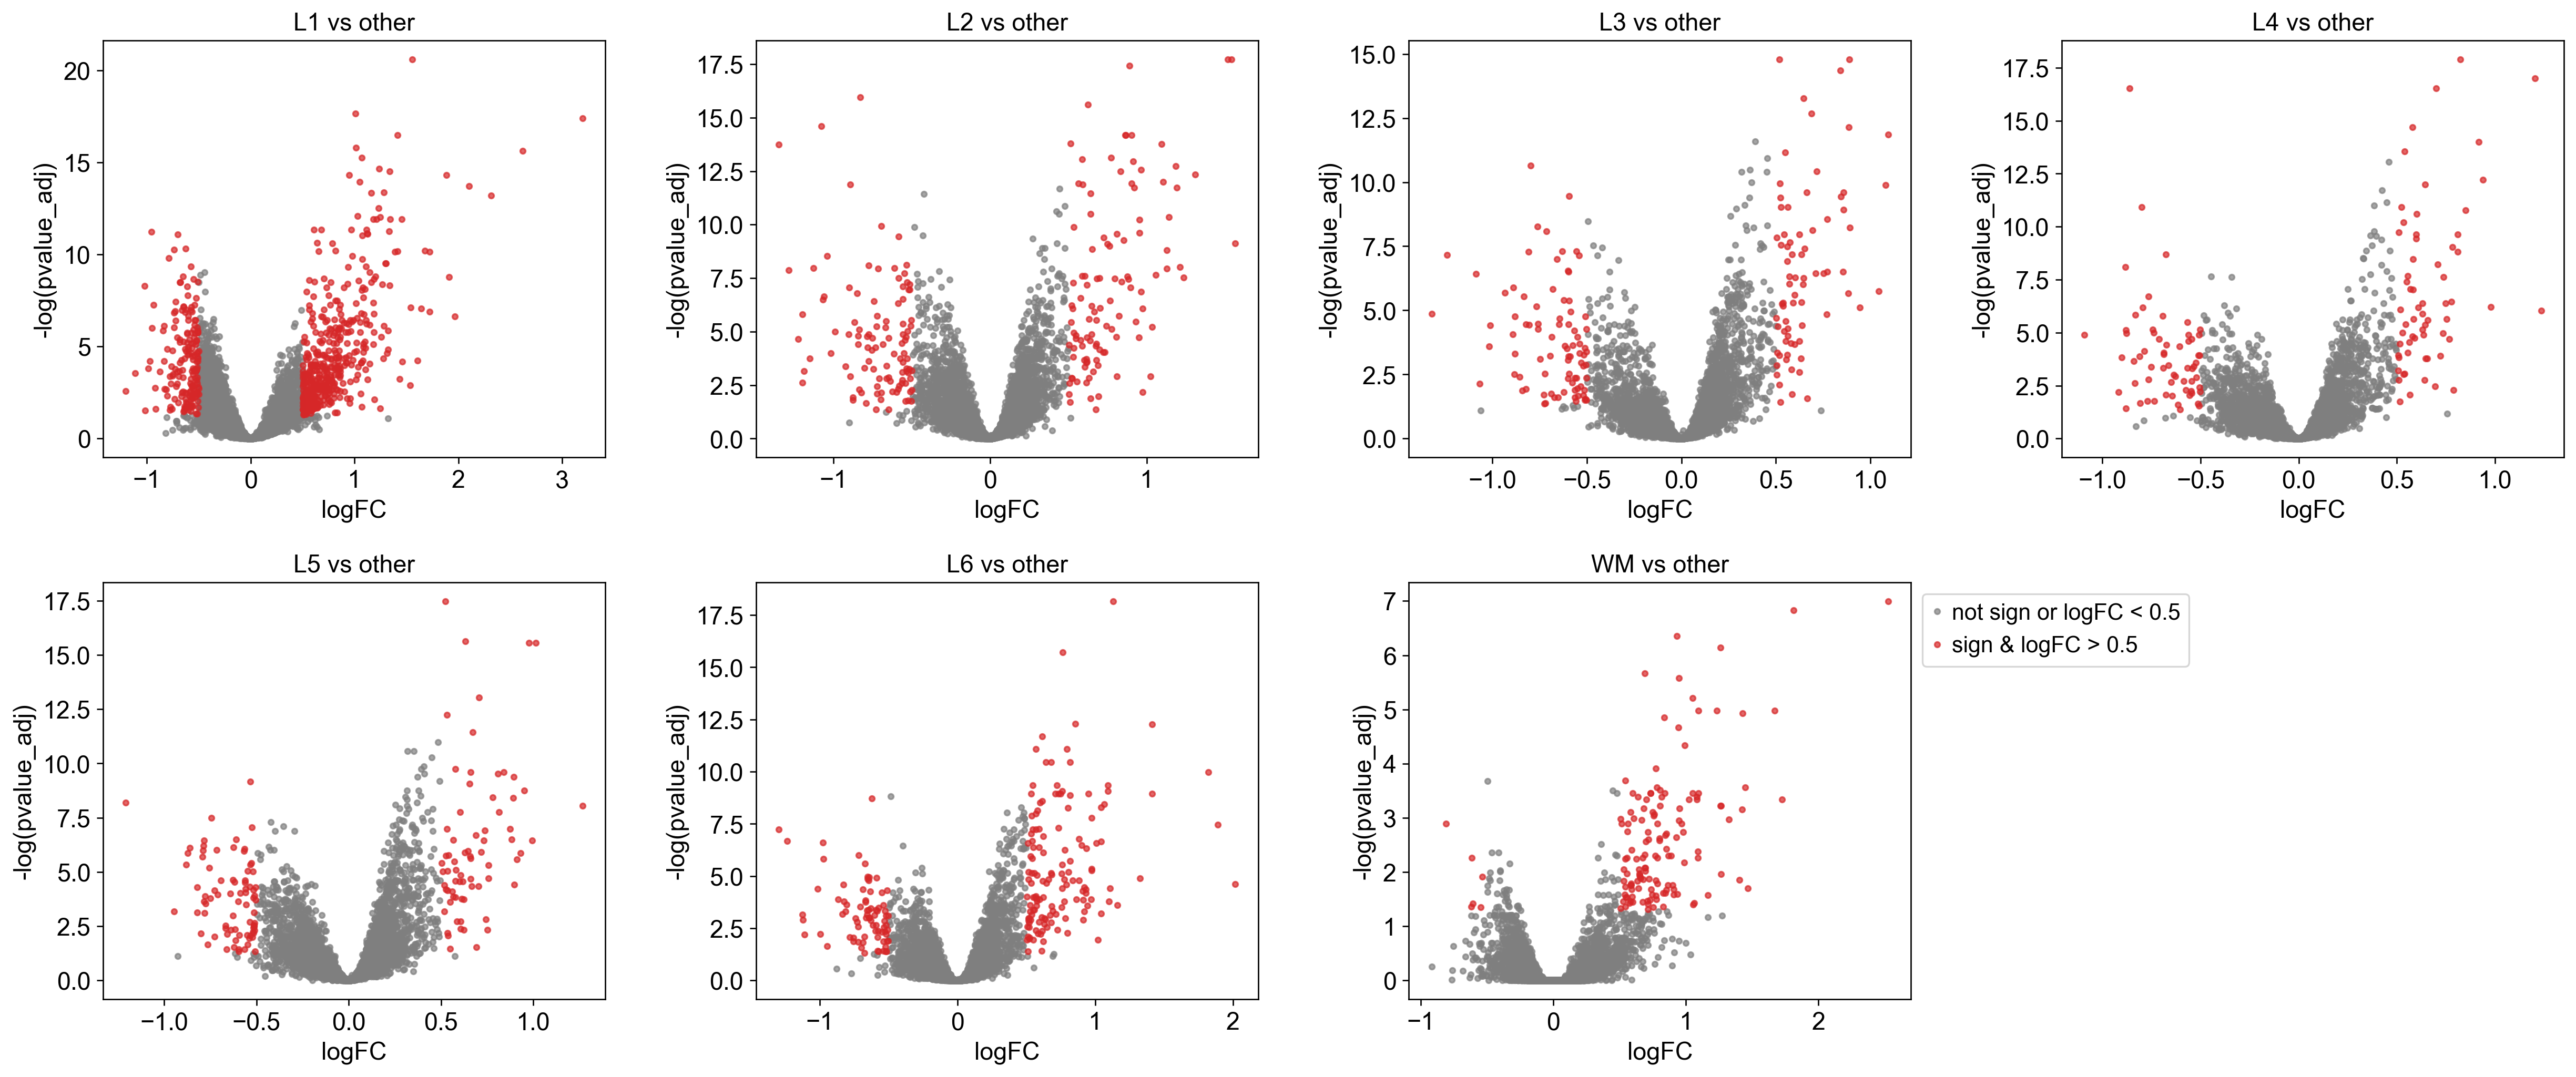

In [17]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(human_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [18]:
print("Summary for chimpanzee")
summary_de(chimp_de)

Summary for chimpanzee


L1    L2    L3    L4    L5    L6    WM
up_reg     574   262   372   401   209   103    33
not_sign  6490  7127  7013  6949  7255  7394  7497
down_reg   477   152   156   191    77    44    11

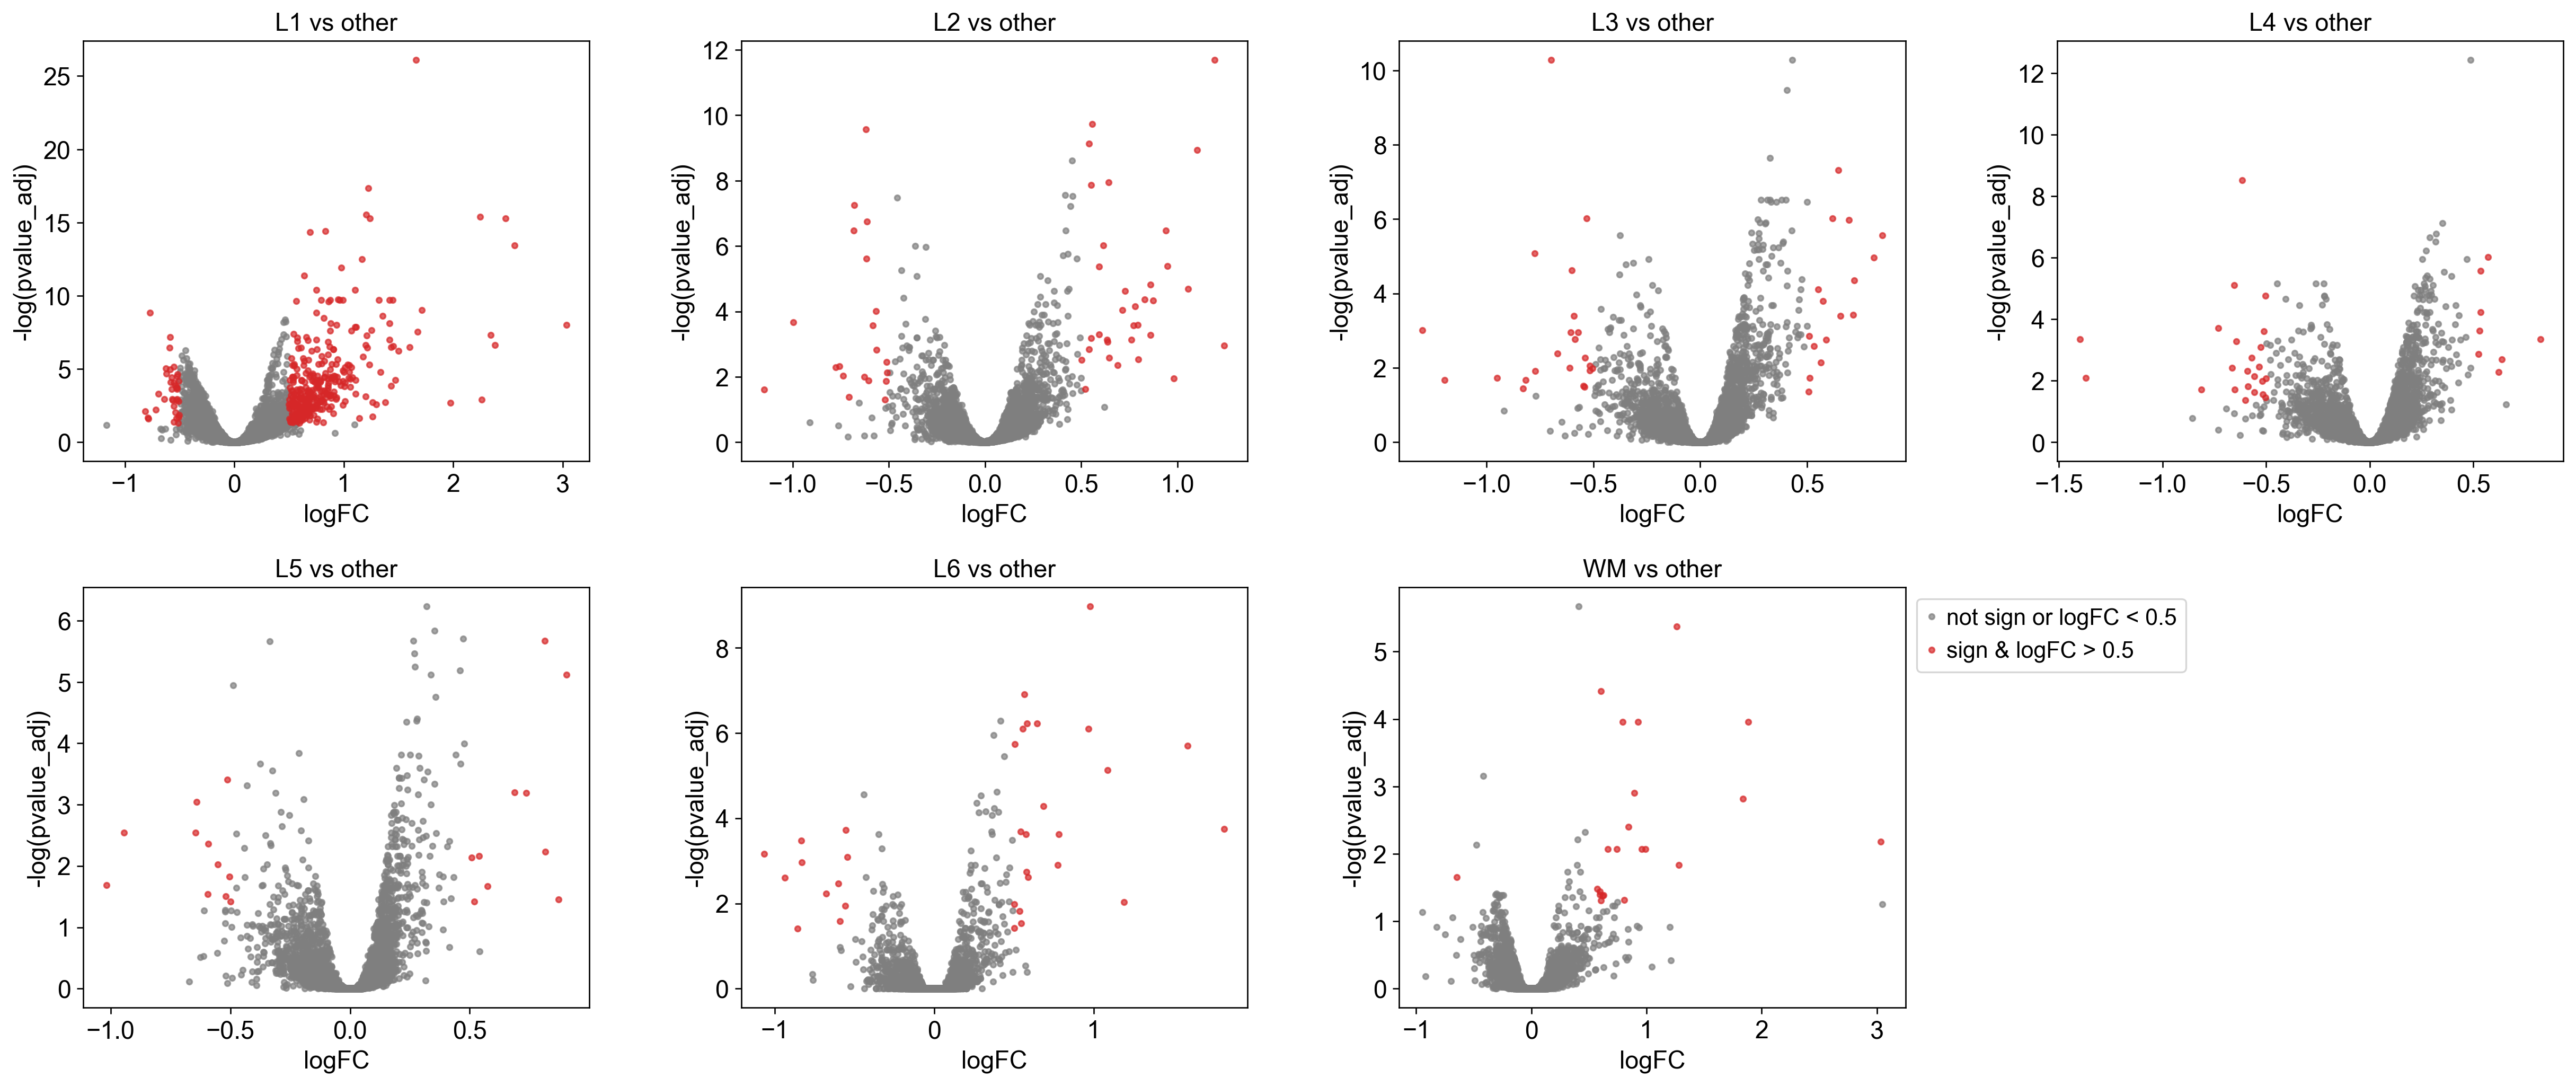

In [19]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(chimp_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

In [20]:
print("Summary for macaque")
summary_de(macaque_de)

Summary for macaque


L1    L2    L3    L4    L5    L6    WM
up_reg     781   706  1063   843   724   281  1208
not_sign  6363  6637  6179  6416  6571  7343  5213
down_reg   670   471   572   555   519   190  1393

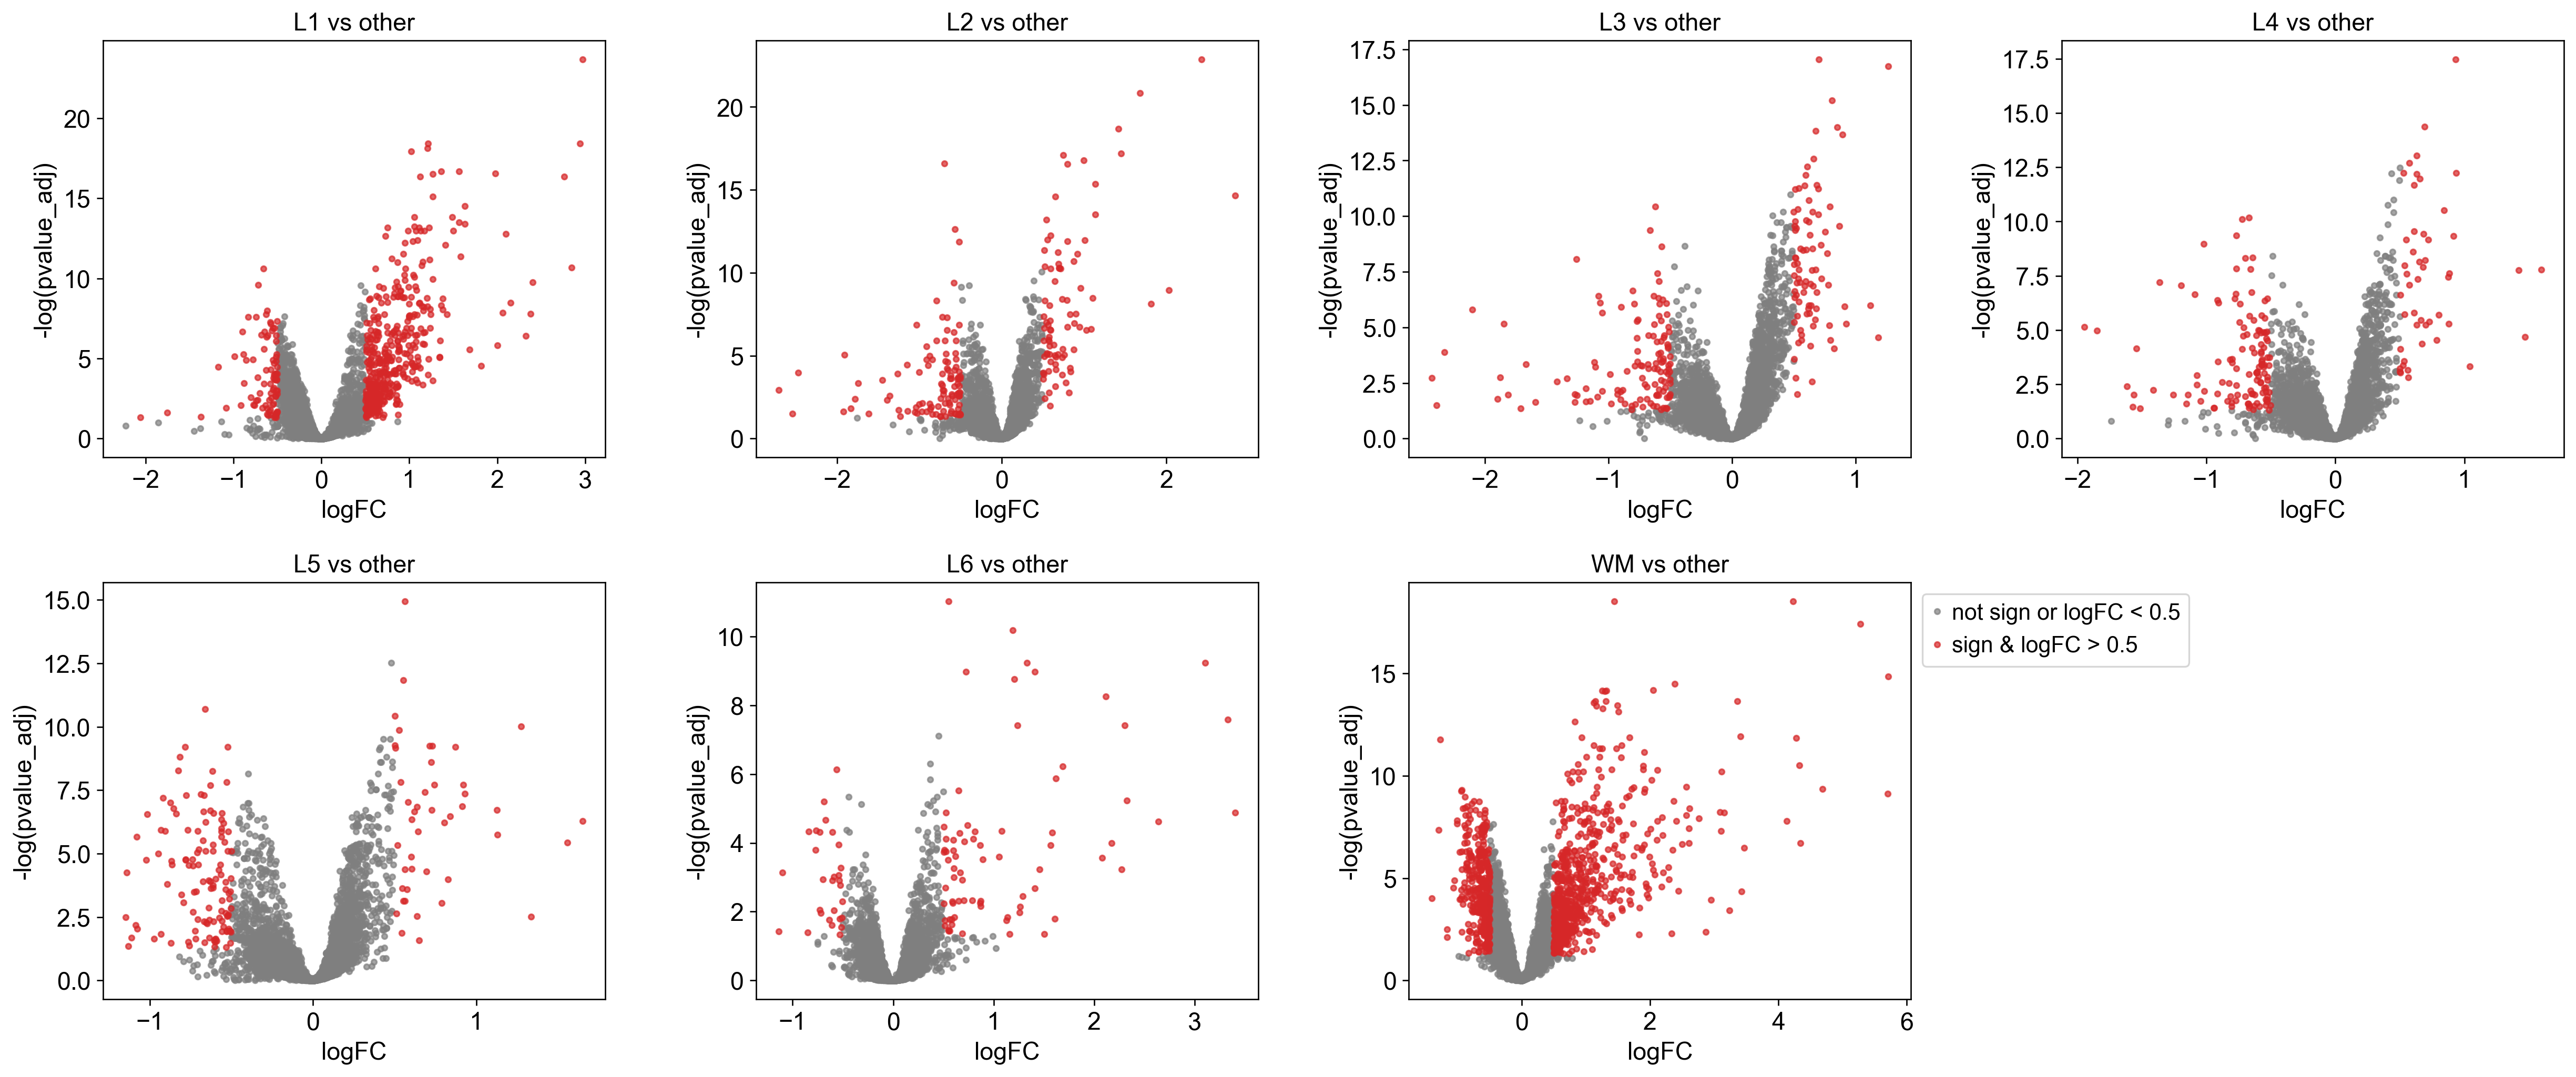

In [21]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(macaque_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = ((df.p_val_adj < 0.05) & (df.logFC.abs() > 0.5))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    if layer == 'WM':
        ax.legend(['not sign or logFC < 0.5', 'sign & logFC > 0.5'], loc="upper left", bbox_to_anchor=(1,1))
fig.delaxes(axes[1, 3])

We can see that WM in macaque is considerably different from other layers

## Marker genes

Let's leave only upregulated marker genes

In [22]:
human_markers = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in human_de.items()}
chimp_markers = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in chimp_de.items()}
macaque_markers = {layer: df[(df.p_val_adj < 0.05) & (df.logFC > 0)].index for layer, df in macaque_de.items()}

### Human

Let's look at pca first

computing PCA
    with n_comps=34
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


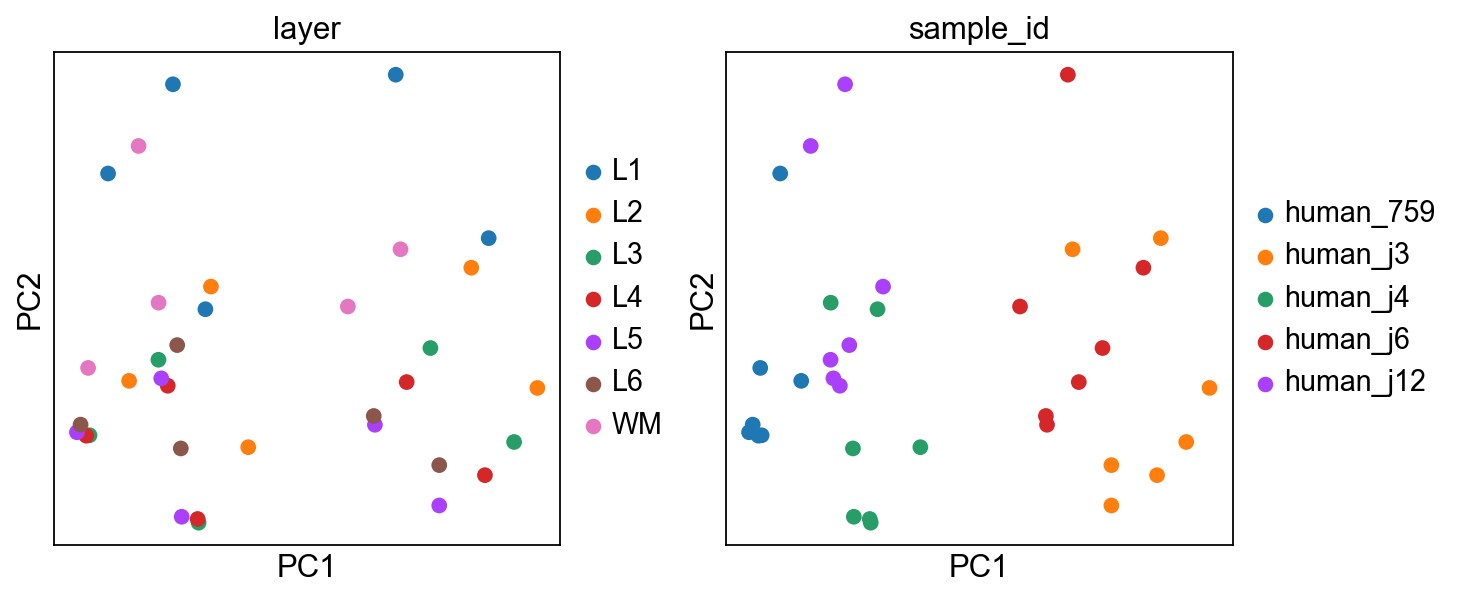

In [23]:
adata_subs = adata_pb[adata_pb.obs.condition == 'human', :].copy()
sc.pp.pca(adata_subs)
sc.pl.pca(adata_subs, color=['layer', 'sample_id'], size=200, show=True, ncols=2)

In [24]:
velmesh_df = pd.read_excel('results/markers_velmeshev.xlsx', index_col=0)
velmesh_df = velmesh_df[velmesh_df.age_max.isin(['3rd trimester', '2nd trimester', '0-1 years'])]
velmesh_df.head()

diff lineage    pattern        age_mid        age_max  \
name                                                                            
SGK3_AST_FB      2288.956128  AST_FB  transient  2nd trimester  3rd trimester   
PLCG2_AST_FB     2236.145400  AST_FB  transient  2nd trimester  2nd trimester   
CCDC85A_AST_FB   1778.978101  AST_FB   biphasic  2nd trimester  3rd trimester   
MTRNR2L8_AST_FB  1368.472123  AST_FB  transient  2nd trimester  2nd trimester   
NAV3_AST_FB       698.468192  AST_FB   biphasic  2nd trimester  2nd trimester   

                 Morans_I      gene  count  
name                                        
SGK3_AST_FB      0.104818      SGK3      4  
PLCG2_AST_FB     0.130646     PLCG2      6  
CCDC85A_AST_FB   0.127433   CCDC85A     15  
MTRNR2L8_AST_FB  0.113631  MTRNR2L8      6  
NAV3_AST_FB      0.101472      NAV3     14

In [25]:
velmesh_df.lineage.value_counts()

lineage
AST_FB      238
L2_3        209
OL          151
AST_PP      132
L5_6_IT     129
L5          120
L6          116
SST         115
L4          110
SST_RELN     85
PV_MP        57
SP           57
CALB2        56
CCK          56
VIP          54
RELN         50
PV           48
SV2C         20
NOS          18
MG_2         14
MG_1         13
Name: count, dtype: int64

In [26]:
velm_lin = ['AST_FB', 'L2_3', 'L4', 'L5', 'L5_6_IT', 'L6']
velm_markers_dict = {lin: list(velmesh_df[velmesh_df.lineage == lin].gene.unique()) for lin in velm_lin}

In [27]:
def inter_velm(velm_markers_dict, sp_markers):
    inter_cell_dict = dict()
    for lin in velm_lin:
        cell_mark = set(velm_markers_dict[lin])
        cell_dic = dict()
        for layer, genes in sp_markers.items():
            cell_dic[layer] = list(cell_mark.intersection(set(genes)))
        inter_cell_dict[lin] = cell_dic
    return inter_cell_dict

In [28]:
inter_cell_dict = inter_velm(velm_markers_dict, human_markers)

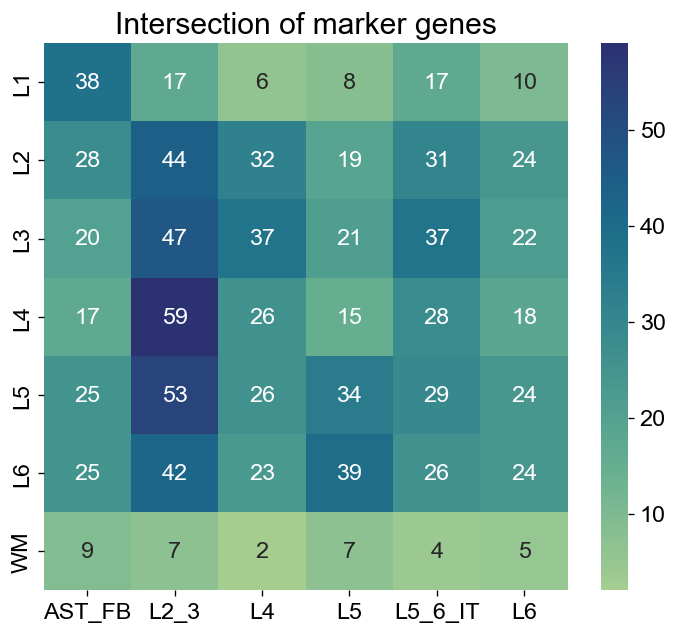

In [29]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection of marker genes', fontsize=18)
plt.grid(False)

Let's leave only unique marker genes

In [30]:
import itertools

def count_unique(marker_dict):
    countgene_list = []
    unique_genes = dict()
    for layer in layers:
        layer_list = []
        for oth_lay in layers:
            if layer == oth_lay:
                marker_genes_other = list(itertools.chain(*[marker_dict[oth_lay] for oth_lay in layers if oth_lay != layer]))
                unique_genes[layer] = set(marker_dict[layer]).difference(marker_genes_other)
                layer_list.append(len(unique_genes[layer]))
            else:
                layer_list.append(len(set(marker_dict[layer]).intersection(marker_dict[oth_lay])))
        countgene_list.append(layer_list)

    countgene_df = pd.DataFrame(countgene_list, index=layers, columns=layers)
    return countgene_df, unique_genes

In [31]:
countgene_human_df, unique_human_genes = count_unique(human_markers)

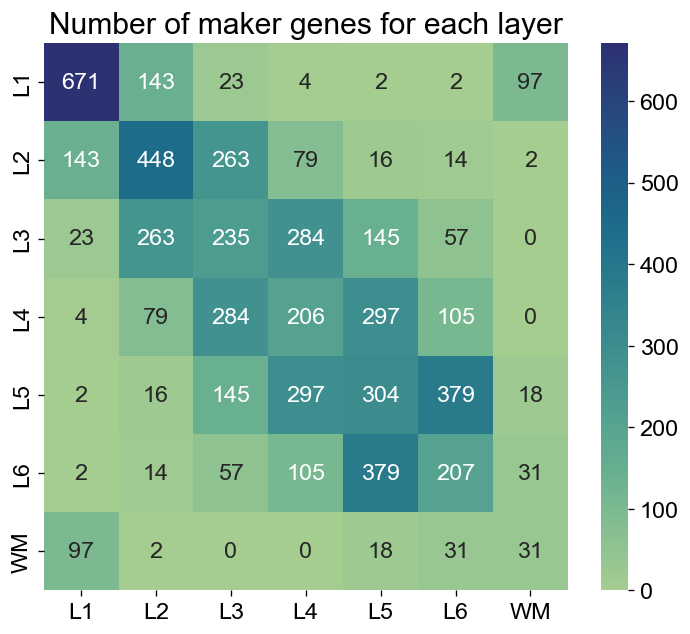

In [32]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_human_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of maker genes for each layer', fontsize=18)
plt.grid(False)

In [33]:
inter_cell_dict = inter_velm(velm_markers_dict, unique_human_genes)

In [34]:
print(inter_cell_dict)

{'AST_FB': {'L1': ['SEMA6A', 'TIMP3', 'FGFR2', 'SEMA5B', 'SFRP1', 'CHD7', 'NID1', 'SASH1', 'FAT1', 'FZD8', 'WWTR1', 'RFX4', 'PLCG2', 'SYNE2', 'OGFRL1', 'EEPD1', 'GPX3', 'ELOVL5', 'ANGPT1', 'PPFIA1', 'DCLK2', 'RGS20', 'NFIC', 'COLEC12', 'HES5', 'SLC6A1'], 'L2': ['ELMO1', 'SHC3', 'AFF3', 'ROBO1', 'PLXNA2', 'TBC1D1', 'KIF26B', 'VAV2', 'SEMA3C', 'TNRC18', 'ZMIZ1', 'LRRC7'], 'L3': ['GRB14', 'LRRTM4', 'LZTS1', 'FDFT1', 'MAP1B'], 'L4': ['FRMPD2', 'PTPRD', 'GRAMD1B', 'SLC22A23'], 'L5': ['ELAVL2', 'RASGEF1A', 'DCX'], 'L6': ['SETBP1', 'EPHA5', 'SATB2', 'NEDD4L', 'SEL1L3'], 'WM': ['STK39']}, 'L2_3': {'L1': ['SYNE2', 'FGFR2', 'ZFHX4', 'BMPR1B', 'MTSS1'], 'L2': ['STAC', 'CLMP', 'THSD7A', 'ROBO1', 'PLXNA2', 'KIF26B', 'LIMCH1', 'SEMA3C', 'AFF3', 'TENM4', 'PGAP1'], 'L3': ['FRMD3', 'FGF13'], 'L4': ['PTPN13', 'CALN1', 'INTS12', 'LYPD6B', 'RARB', 'LRRK1', 'GRAMD1B', 'VWC2L', 'PHLDB2', 'PTPRD', 'LUZP2', 'DPY19L1'], 'L5': ['PROM1', 'LGI1', 'FAM189A1', 'IL1RAP', 'COL12A1', 'SLC24A3'], 'L6': ['GRIP1', 'SATB2

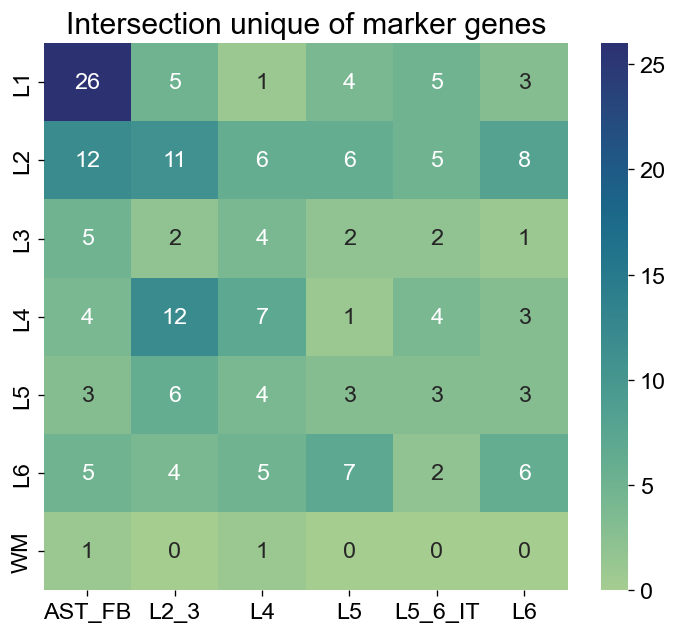

In [35]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection unique of marker genes', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [36]:
top = 20
marker_top_list = []
for layer in layers:
    layer_topmarkers = human_de[layer].loc[list(unique_human_genes[layer])]['logFC'].sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


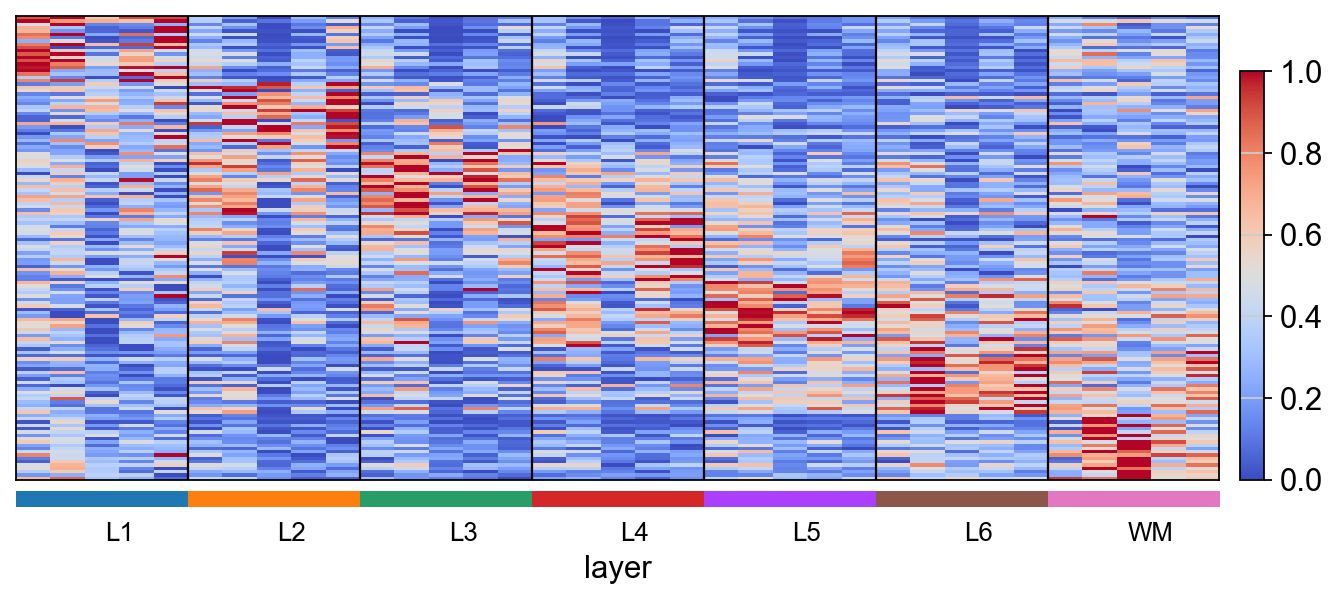

In [37]:
sc.pl.heatmap(adata_pb[adata_pb.obs.condition == 'human', :],
 marker_top_list, groupby='layer', swap_axes=True, standard_scale='var', cmap='coolwarm')

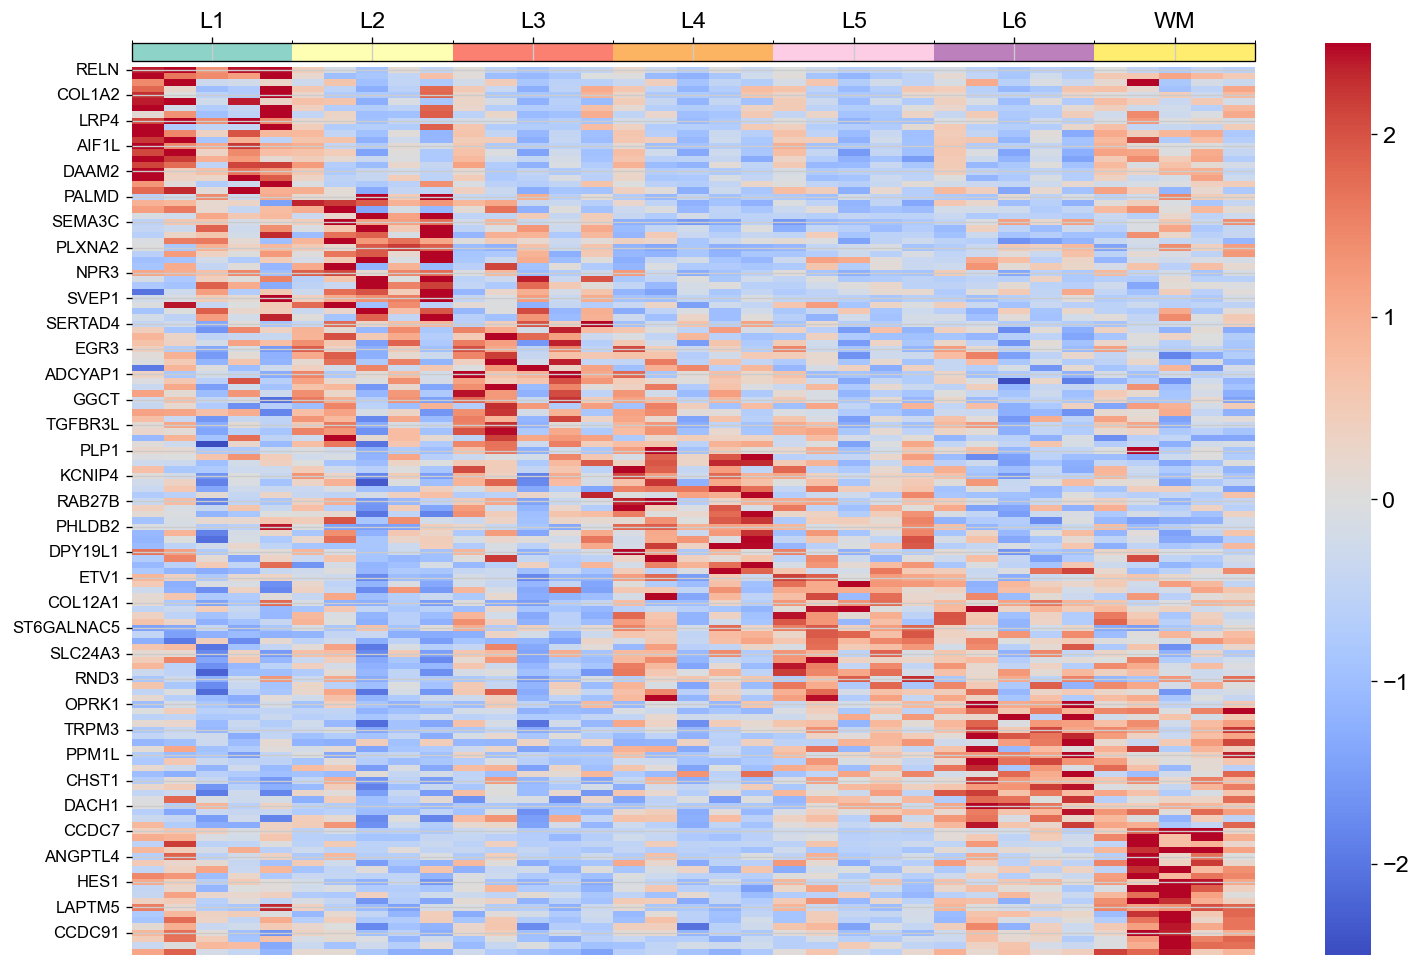

In [38]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'human', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

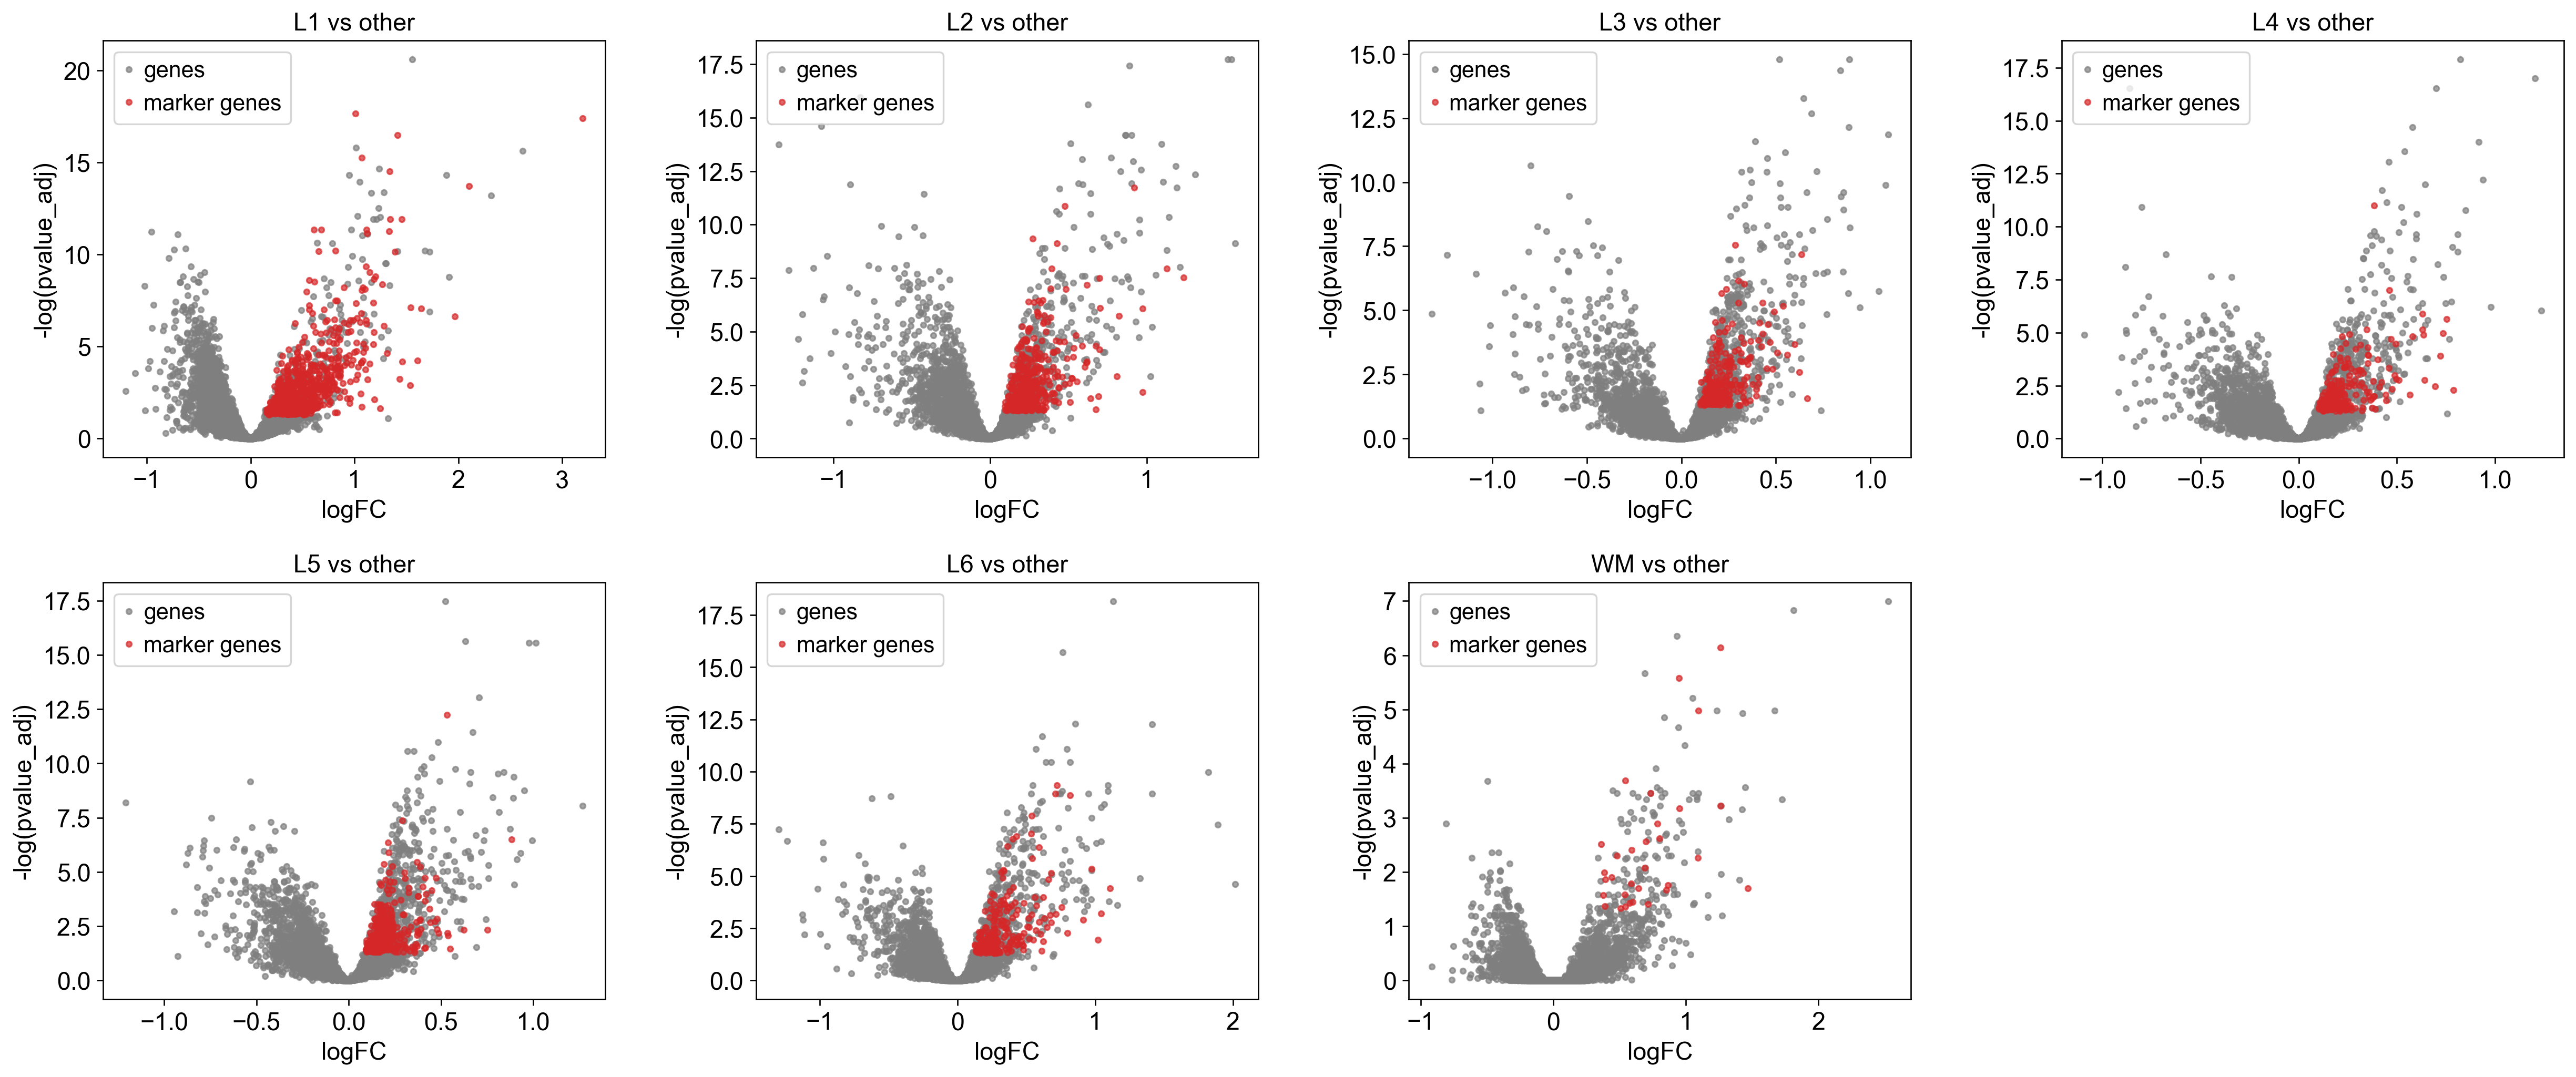

In [39]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(human_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = df.index.isin(list(unique_human_genes[layer]))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    ax.legend(['genes', 'marker genes'], loc="upper left")
fig.delaxes(axes[1, 3])

### Chimp

Let's look at pca plot

computing PCA
    with n_comps=25
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


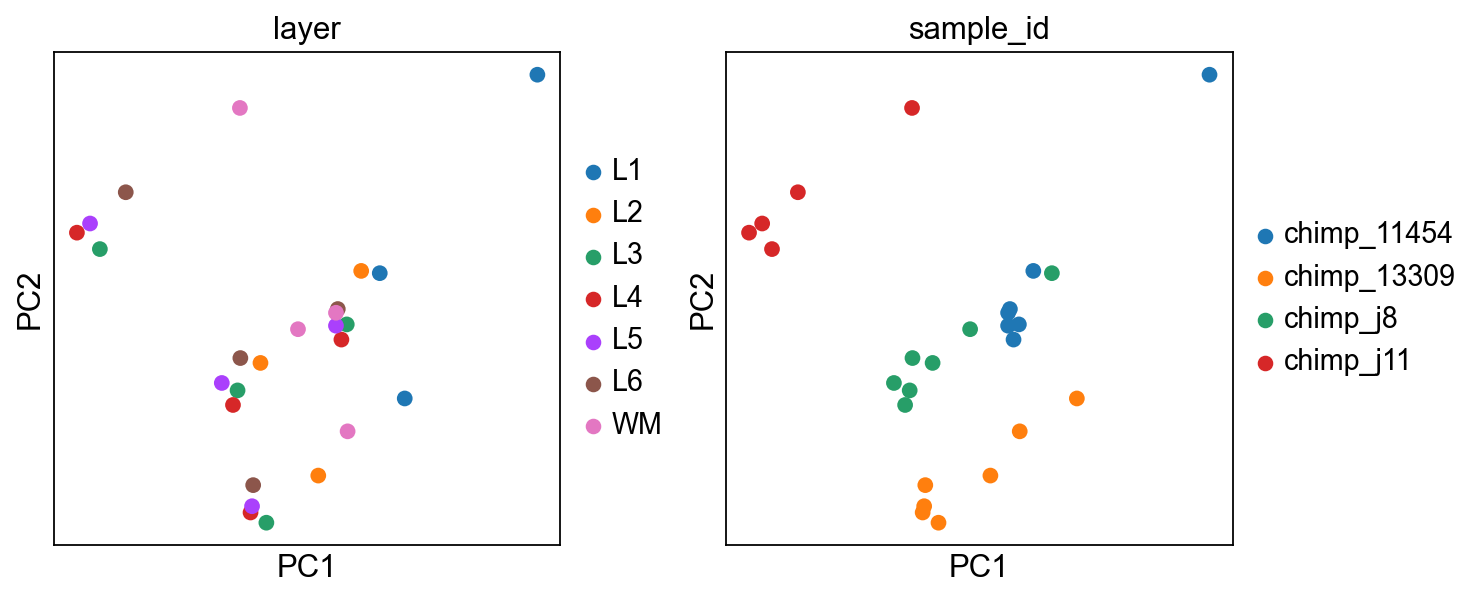

In [40]:
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', :].copy()
sc.pp.pca(adata_subs)
sc.pl.pca(adata_subs, color=['layer', 'sample_id'], size=200, show=True, ncols=2)

In [41]:
inter_cell_dict = inter_velm(velm_markers_dict, chimp_markers)

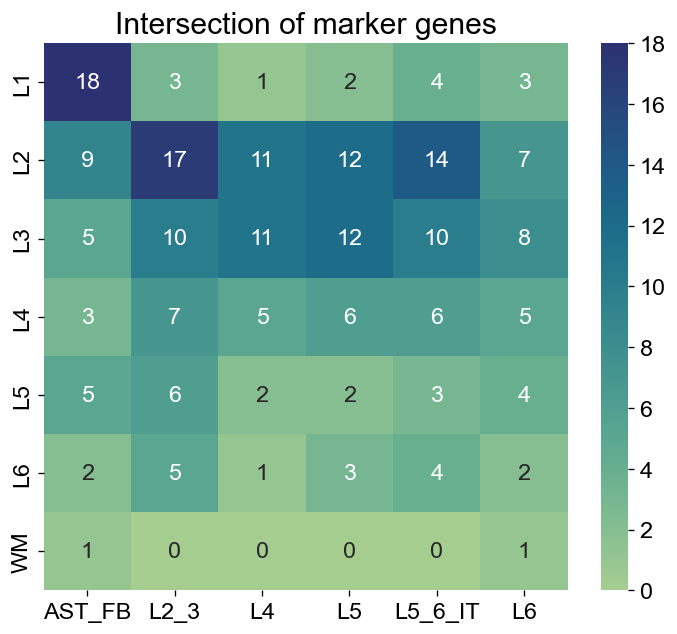

In [42]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection of marker genes', fontsize=18)
plt.grid(False)

Let's leave only unique marker genes

In [43]:
countgene_chimp_df, unique_chimp_genes = count_unique(chimp_markers)

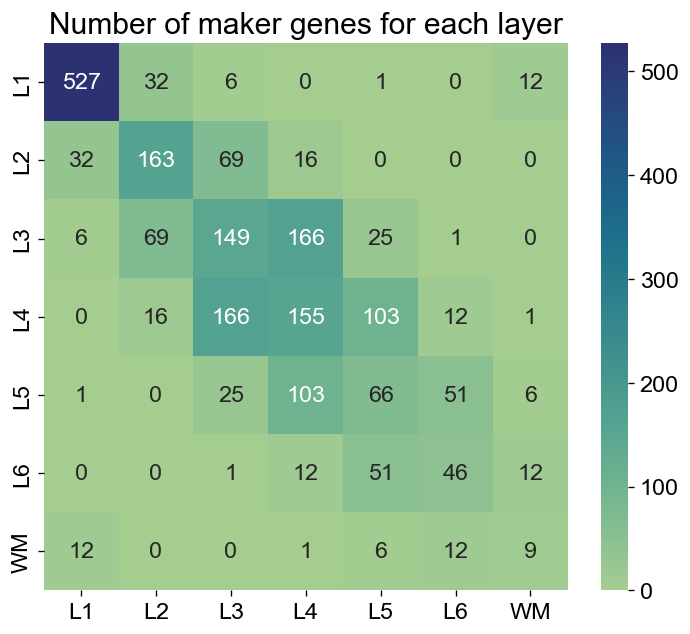

In [44]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_chimp_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of maker genes for each layer', fontsize=18)
plt.grid(False)

In [45]:
inter_cell_dict = inter_velm(velm_markers_dict, unique_chimp_genes)

In [46]:
print(inter_cell_dict)

{'AST_FB': {'L1': ['SEMA6A', 'TNC', 'CD9', 'EEPD1', 'CNN3', 'FGFR2', 'SCD5', 'ELOVL5', 'FAT1', 'LRIG1', 'NID1', 'SASH1', 'WWTR1', 'AKAP12', 'NFIC', 'RFX4'], 'L2': ['SEMA3C', 'ZMIZ1', 'MOXD1', 'CDH4', 'AUTS2'], 'L3': ['PPFIA2', 'LIPG'], 'L4': ['FRMPD2'], 'L5': ['DCC', 'BCL11A', 'FBXO32'], 'L6': ['NR4A2', 'SEL1L3'], 'WM': ['SMOC1']}, 'L2_3': {'L1': ['VCAN', 'FGFR2', 'CNTNAP4'], 'L2': ['MDGA1', 'PBX1', 'FRY', 'EPS8', 'PRSS12', 'MEIS2', 'SEMA3C', 'TIAM2', 'CDH4', 'ADAMTSL1', 'AUTS2'], 'L3': ['LRRC4C', 'ACTN2'], 'L4': ['APBB2', 'TENM1'], 'L5': ['HS3ST2', 'DCC'], 'L6': ['PTPRK', 'PROM1'], 'WM': []}, 'L4': {'L1': ['RPL3'], 'L2': ['NAV2', 'MARCKSL1', 'EPS8', 'STMN1', 'TIAM2', 'CDH4', 'AUTS2'], 'L3': ['EEF1A2', 'UCHL1', 'MYT1L', 'ENOX1', 'RASGRF2', 'TUBA1A'], 'L4': ['CFL1', 'PEBP1'], 'L5': [], 'L6': [], 'WM': []}, 'L5': {'L1': ['RPS26', 'VCAN'], 'L2': ['EIF4A1', 'ADAMTSL1', 'PHPT1', 'SEMA3C'], 'L3': ['EEF1A2', 'VSTM2L'], 'L4': ['MARK1', 'RAPGEF5', 'KCNAB1'], 'L5': [], 'L6': ['NR4A2', 'NGEF'], '

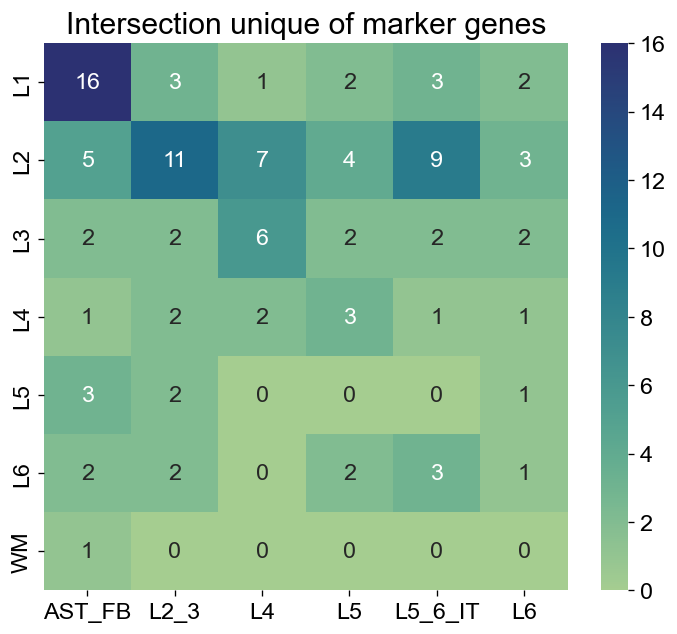

In [47]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection unique of marker genes', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [48]:
top = 20
marker_top_list = []
for layer in layers:
    layer_topmarkers = chimp_de[layer].loc[list(unique_chimp_genes[layer])]['logFC'].sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


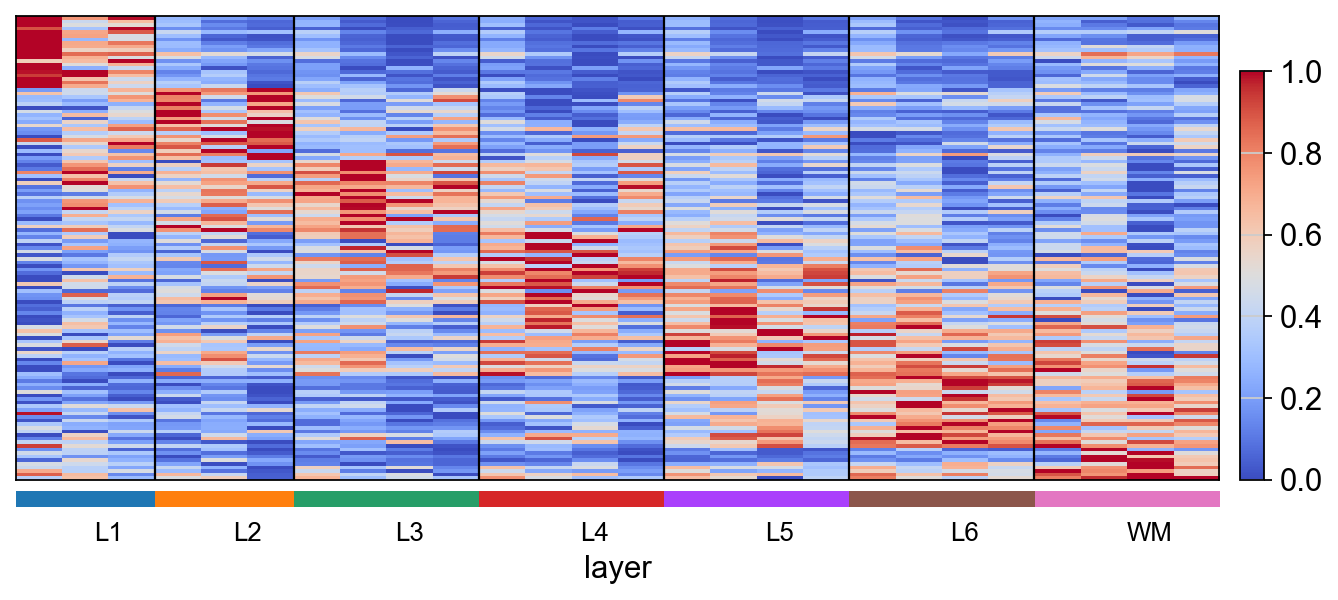

In [49]:
sc.pl.heatmap(adata_pb[adata_pb.obs.condition == 'chimp', :],
 marker_top_list, groupby='layer', swap_axes=True, standard_scale='var', cmap='coolwarm')

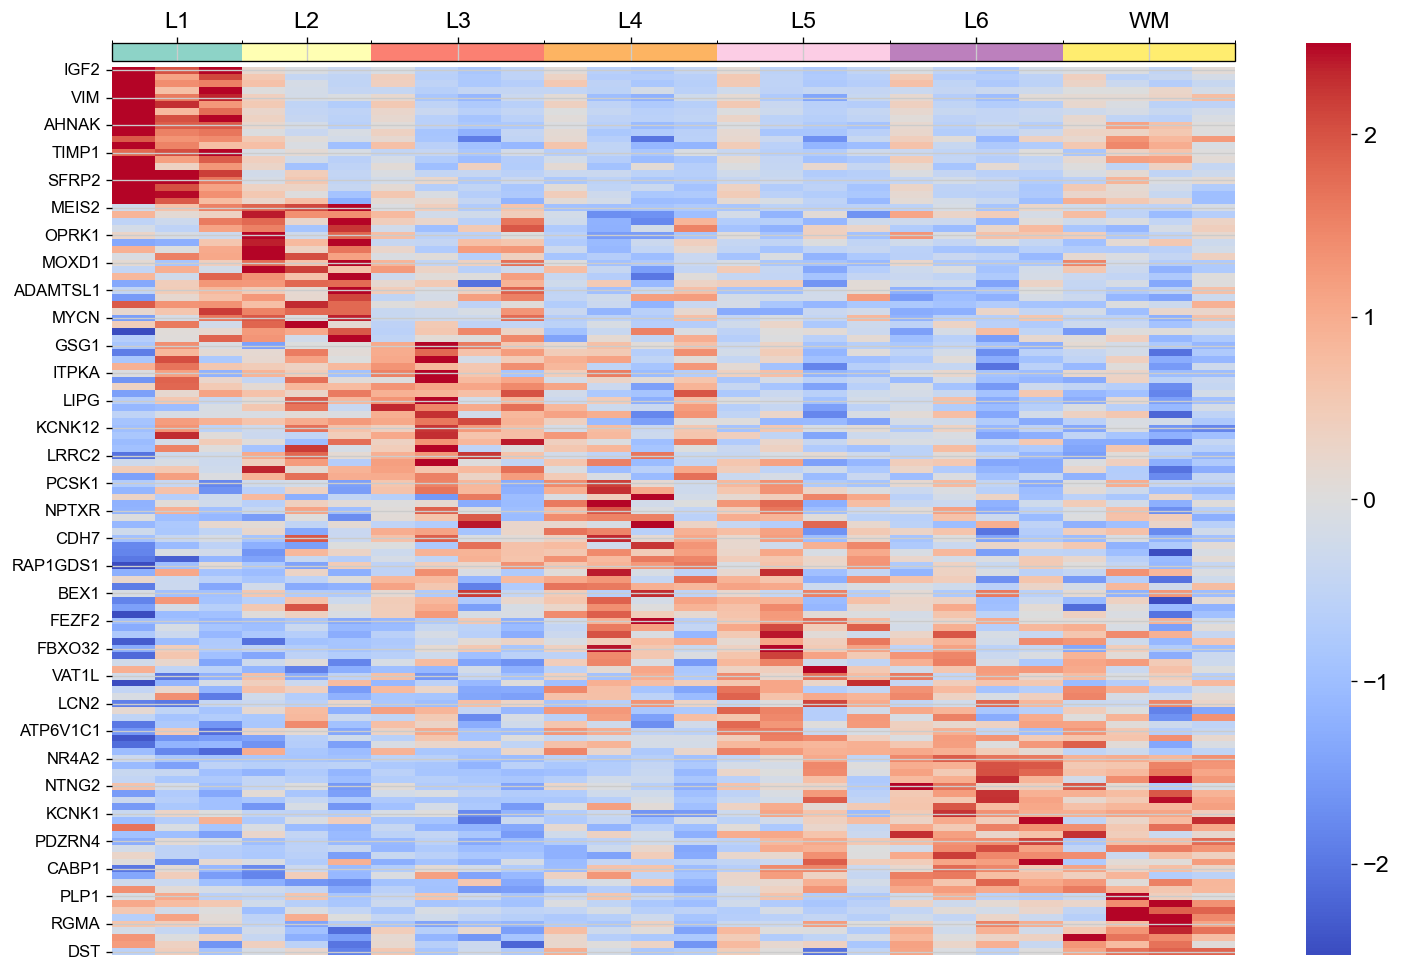

In [50]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

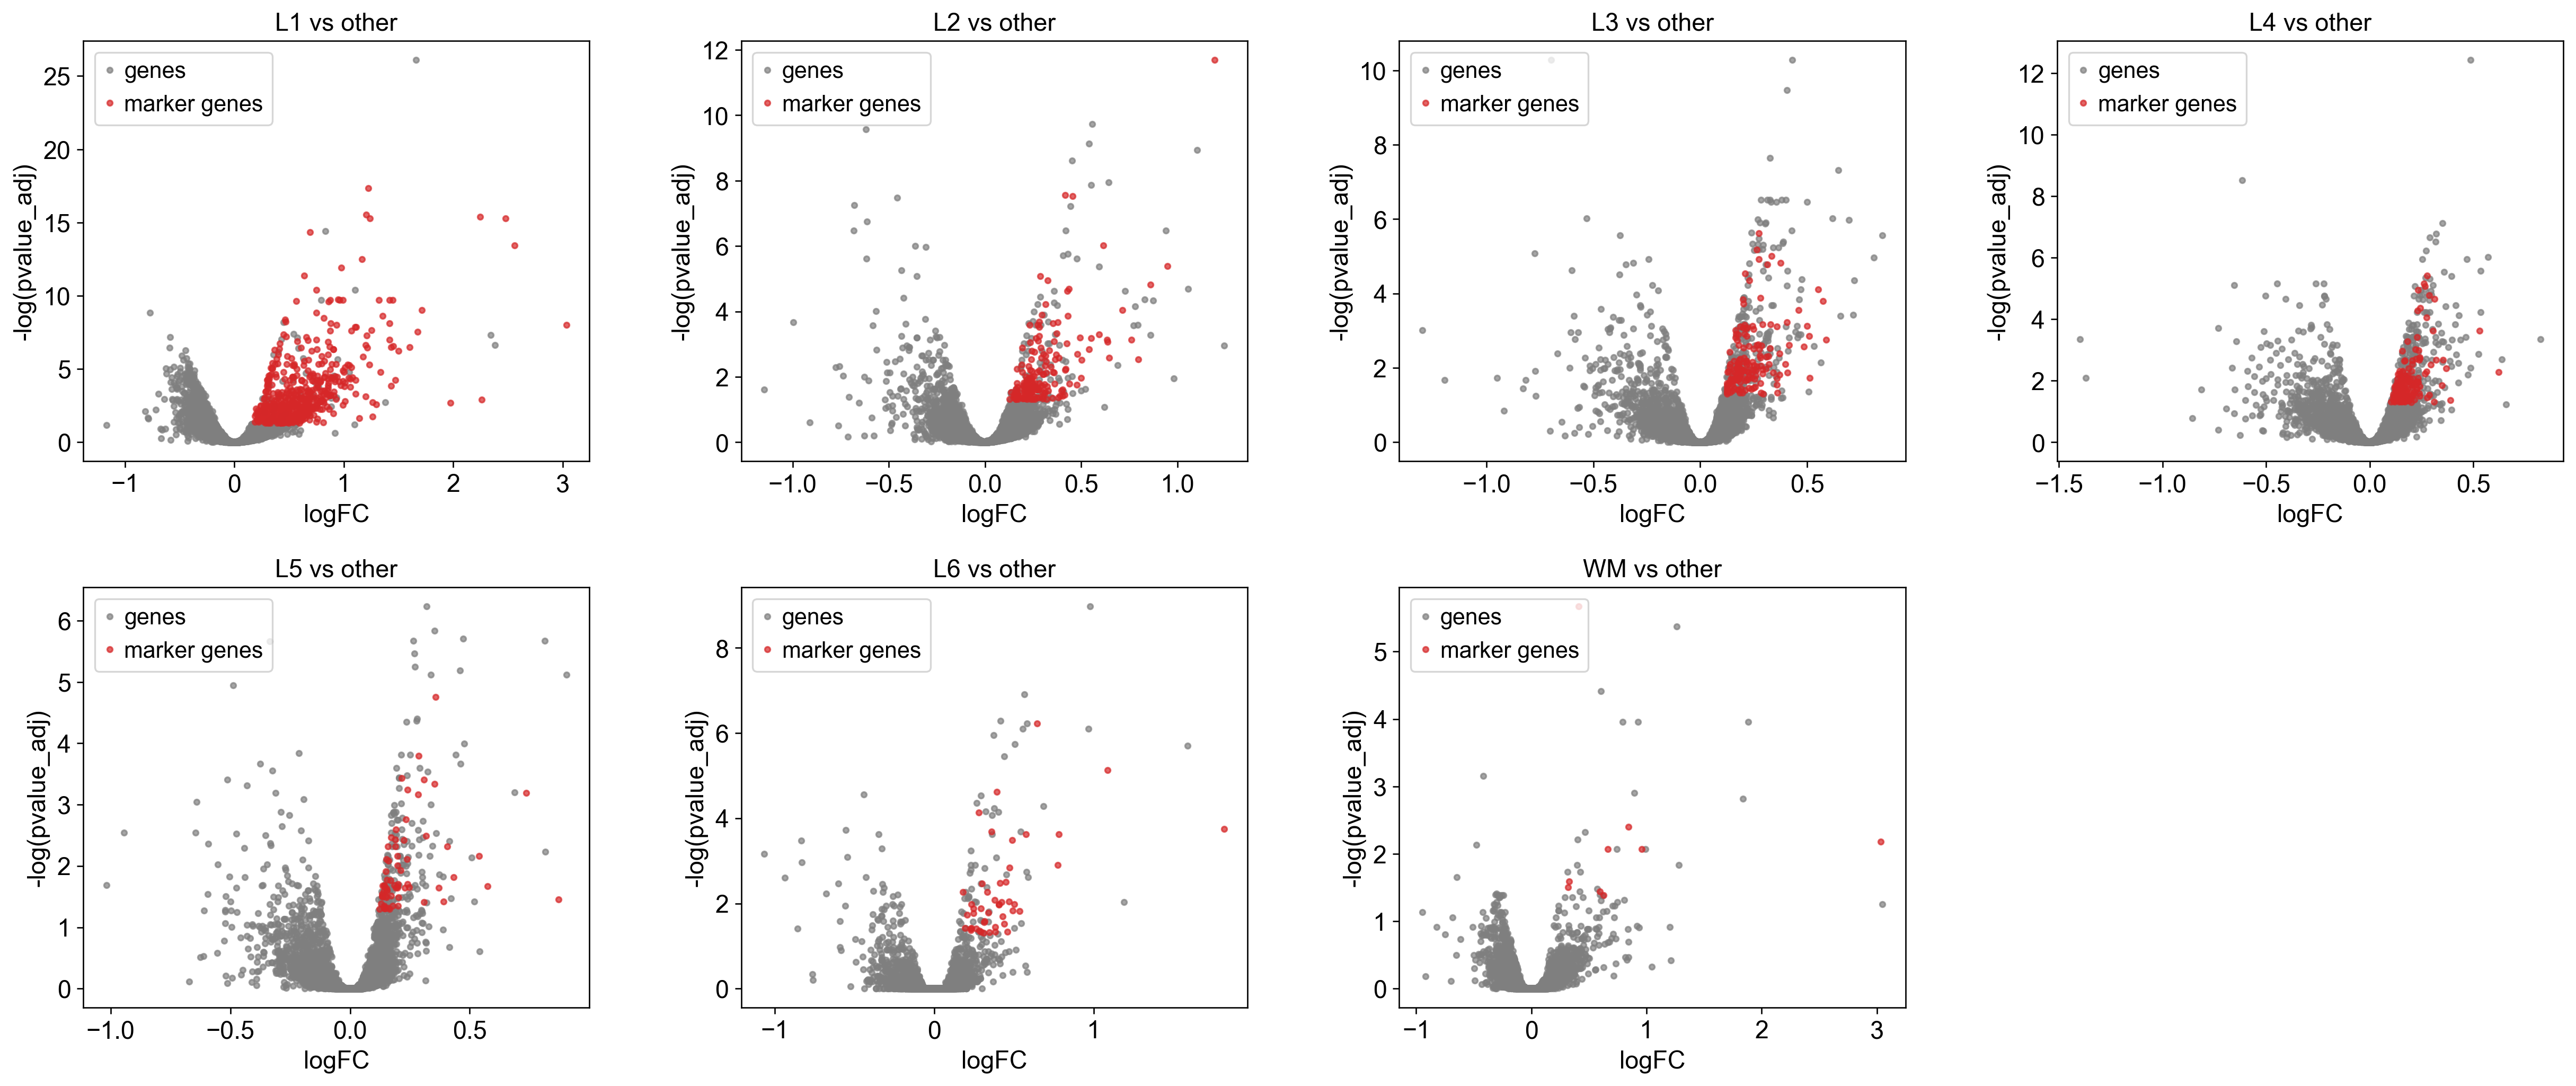

In [51]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(chimp_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = df.index.isin(list(unique_chimp_genes[layer]))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    ax.legend(['genes', 'marker genes'], loc="upper left")
fig.delaxes(axes[1, 3])

### Macaque

Let's look at PCA plot first

computing PCA
    with n_comps=27
    finished (0:00:00)


d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


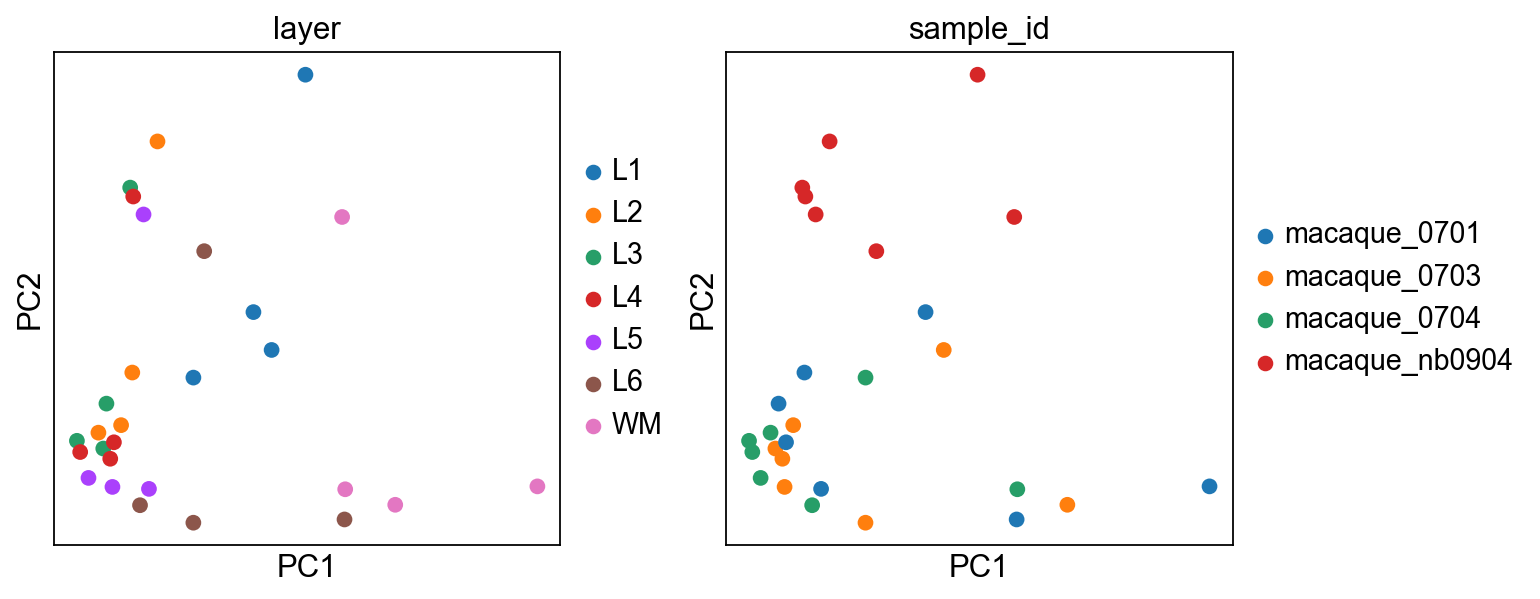

In [52]:
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', :].copy()
sc.pp.pca(adata_subs)
sc.pl.pca(adata_subs, color=['layer', 'sample_id'], size=200, show=True, ncols=2)

In [53]:
inter_cell_dict = inter_velm(velm_markers_dict, macaque_markers)

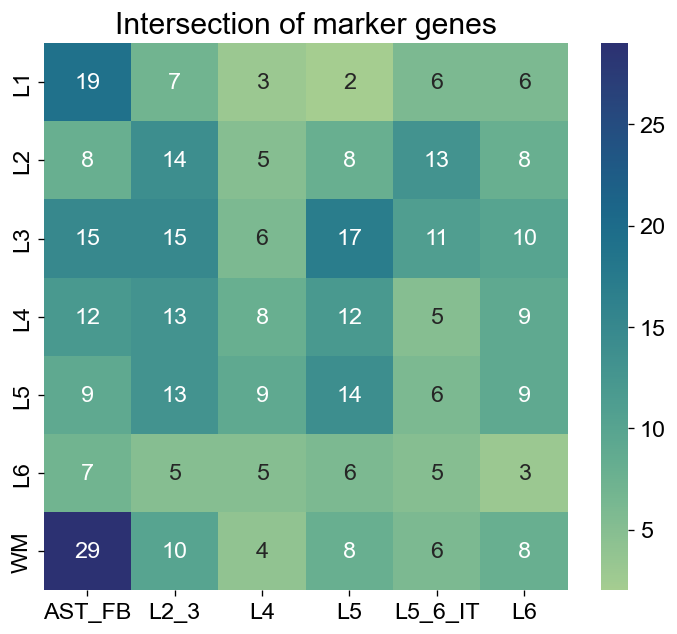

In [54]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection of marker genes', fontsize=18)
plt.grid(False)

Let's leave only unique marker genes

In [55]:
countgene_macaque_df, unique_macaque_genes = count_unique(macaque_markers)

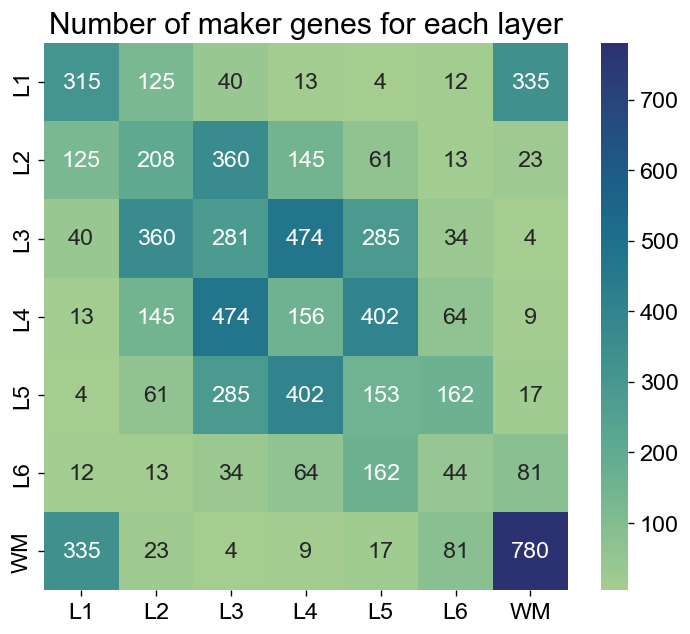

In [56]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_macaque_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of maker genes for each layer', fontsize=18)
plt.grid(False)

In [57]:
inter_cell_dict = inter_velm(velm_markers_dict, unique_macaque_genes)

In [58]:
print(inter_cell_dict)

{'AST_FB': {'L1': ['ZNF423', 'CUX1', 'NID1', 'AKAP12', 'WSCD1', 'NFIC'], 'L2': [], 'L3': ['ELMO1', 'FDFT1', 'MAPT', 'GRIN2A', 'PLXNA2', 'SREBF2', 'PLCB1'], 'L4': ['TTYH3', 'FRMPD2', 'FBXO32'], 'L5': ['NRG1'], 'L6': ['NFIB'], 'WM': ['CD9', 'TMEM108', 'RNF130', 'IGF2BP2', 'SEMA5B', 'LDLRAD3', 'SFRP1', 'CD44', 'CHD7', 'CTBP2', 'MOXD1', 'TFDP2', 'SMOC1', 'INSIG1', 'DCLK2', 'ABTB2', 'HSPB8', 'JAM3', 'STK39', 'QKI']}, 'L2_3': {'L1': ['ZBTB20'], 'L2': ['MDGA1', 'KLHL4', 'PID1', 'MEIS2'], 'L3': ['APOO', 'PLXNA2', 'FGF12'], 'L4': ['KLHDC8A', 'IL1RAP', 'RORB'], 'L5': ['ALCAM', 'KLHL1', 'SSTR2', 'NRG1'], 'L6': ['SGSM1', 'NFIB'], 'WM': ['ANK3', 'PROM1', 'TESK2', 'TMEM108', 'ADCY8', 'IGF2BP2', 'VCAN']}, 'L4': {'L1': [], 'L2': ['ANO4'], 'L3': ['RAC3'], 'L4': [], 'L5': [], 'L6': ['ANK2'], 'WM': ['FMNL2', 'MARCKSL1', 'TMEM108']}, 'L5': {'L1': ['PPP1R1B'], 'L2': ['CYP26A1'], 'L3': ['APOO', 'NTRK3', 'BACE2', 'RGS6', 'PLXNA2', 'GAS7'], 'L4': ['KCNAB1'], 'L5': ['SSTR2', 'NRG1'], 'L6': [], 'WM': ['TMEM108'

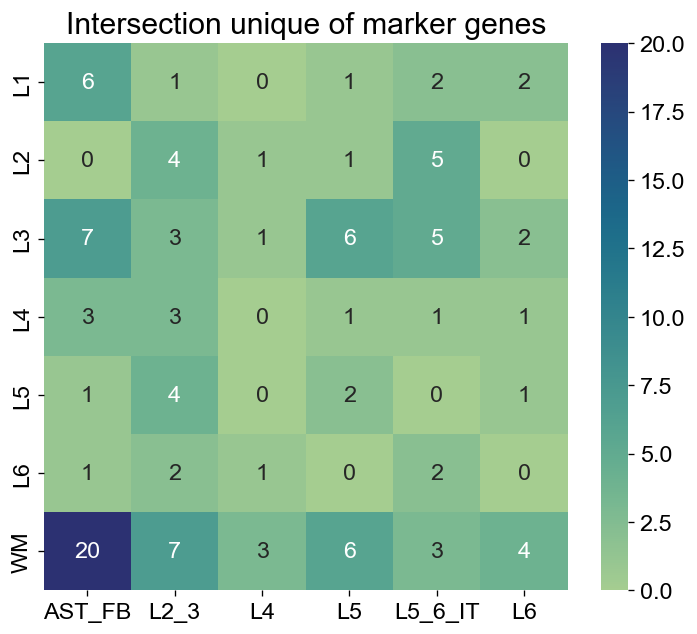

In [59]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection unique of marker genes', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [60]:
top = 20
marker_top_list = []
for layer in layers:
    layer_topmarkers = macaque_de[layer].loc[list(unique_macaque_genes[layer])]['logFC'].sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

d:\Projects\spatialMPFC\venv\lib\site-packages\scanpy\plotting\_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


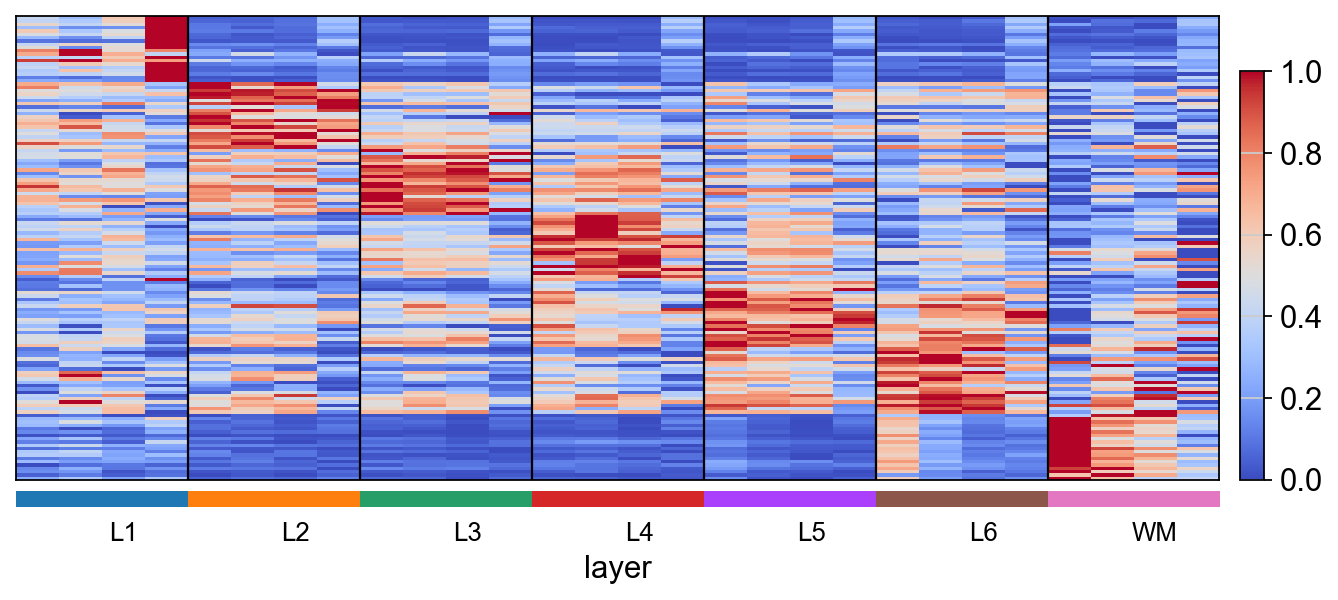

In [61]:
sc.pl.heatmap(adata_pb[adata_pb.obs.condition == 'macaque', :],
 marker_top_list, groupby='layer', swap_axes=True, standard_scale='var', cmap='coolwarm')

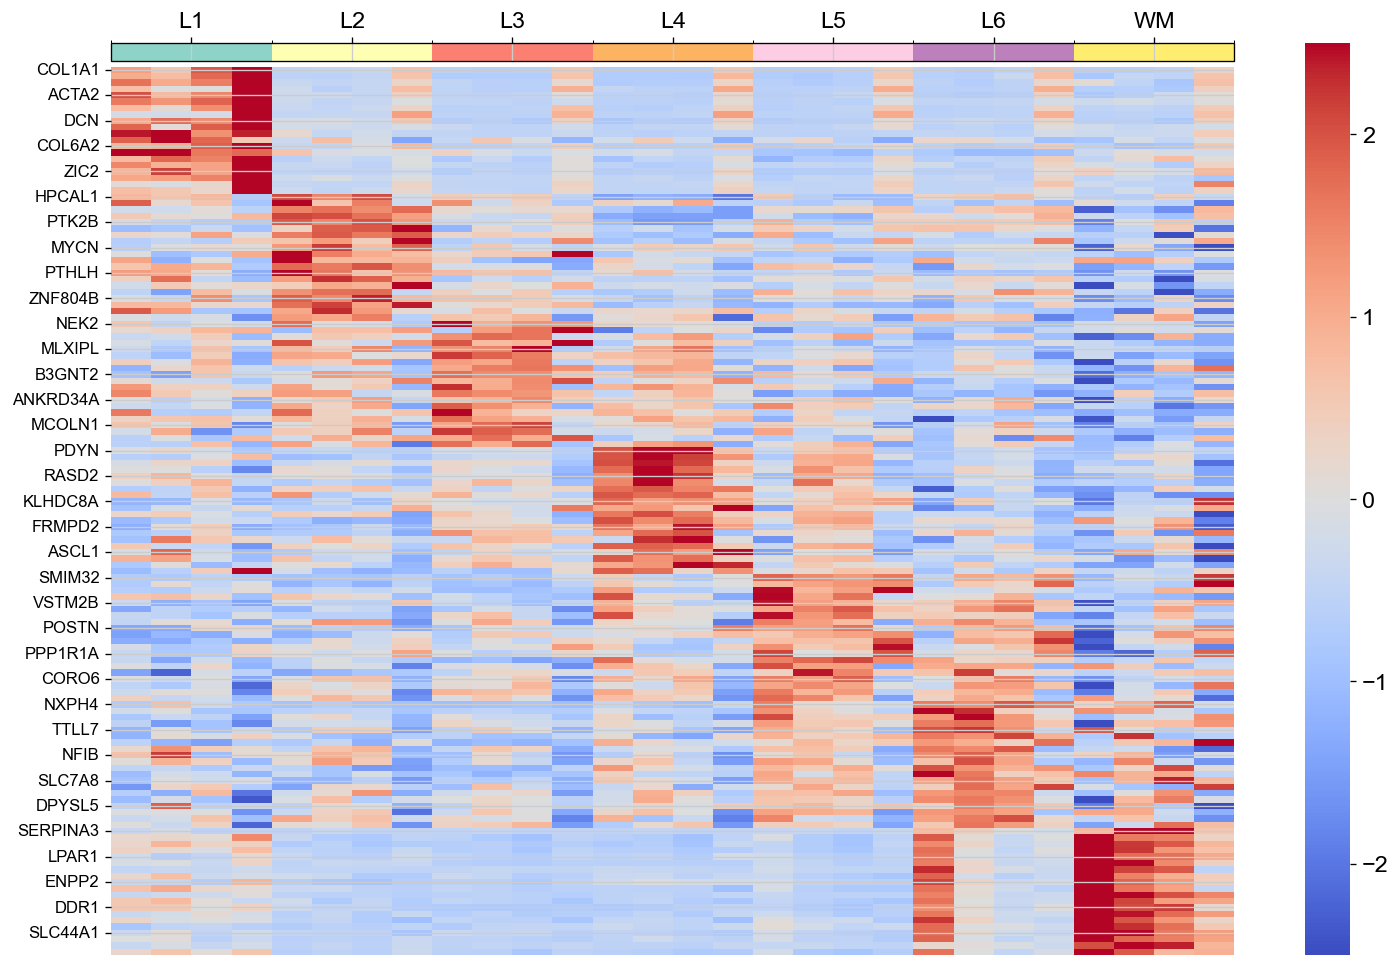

In [62]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

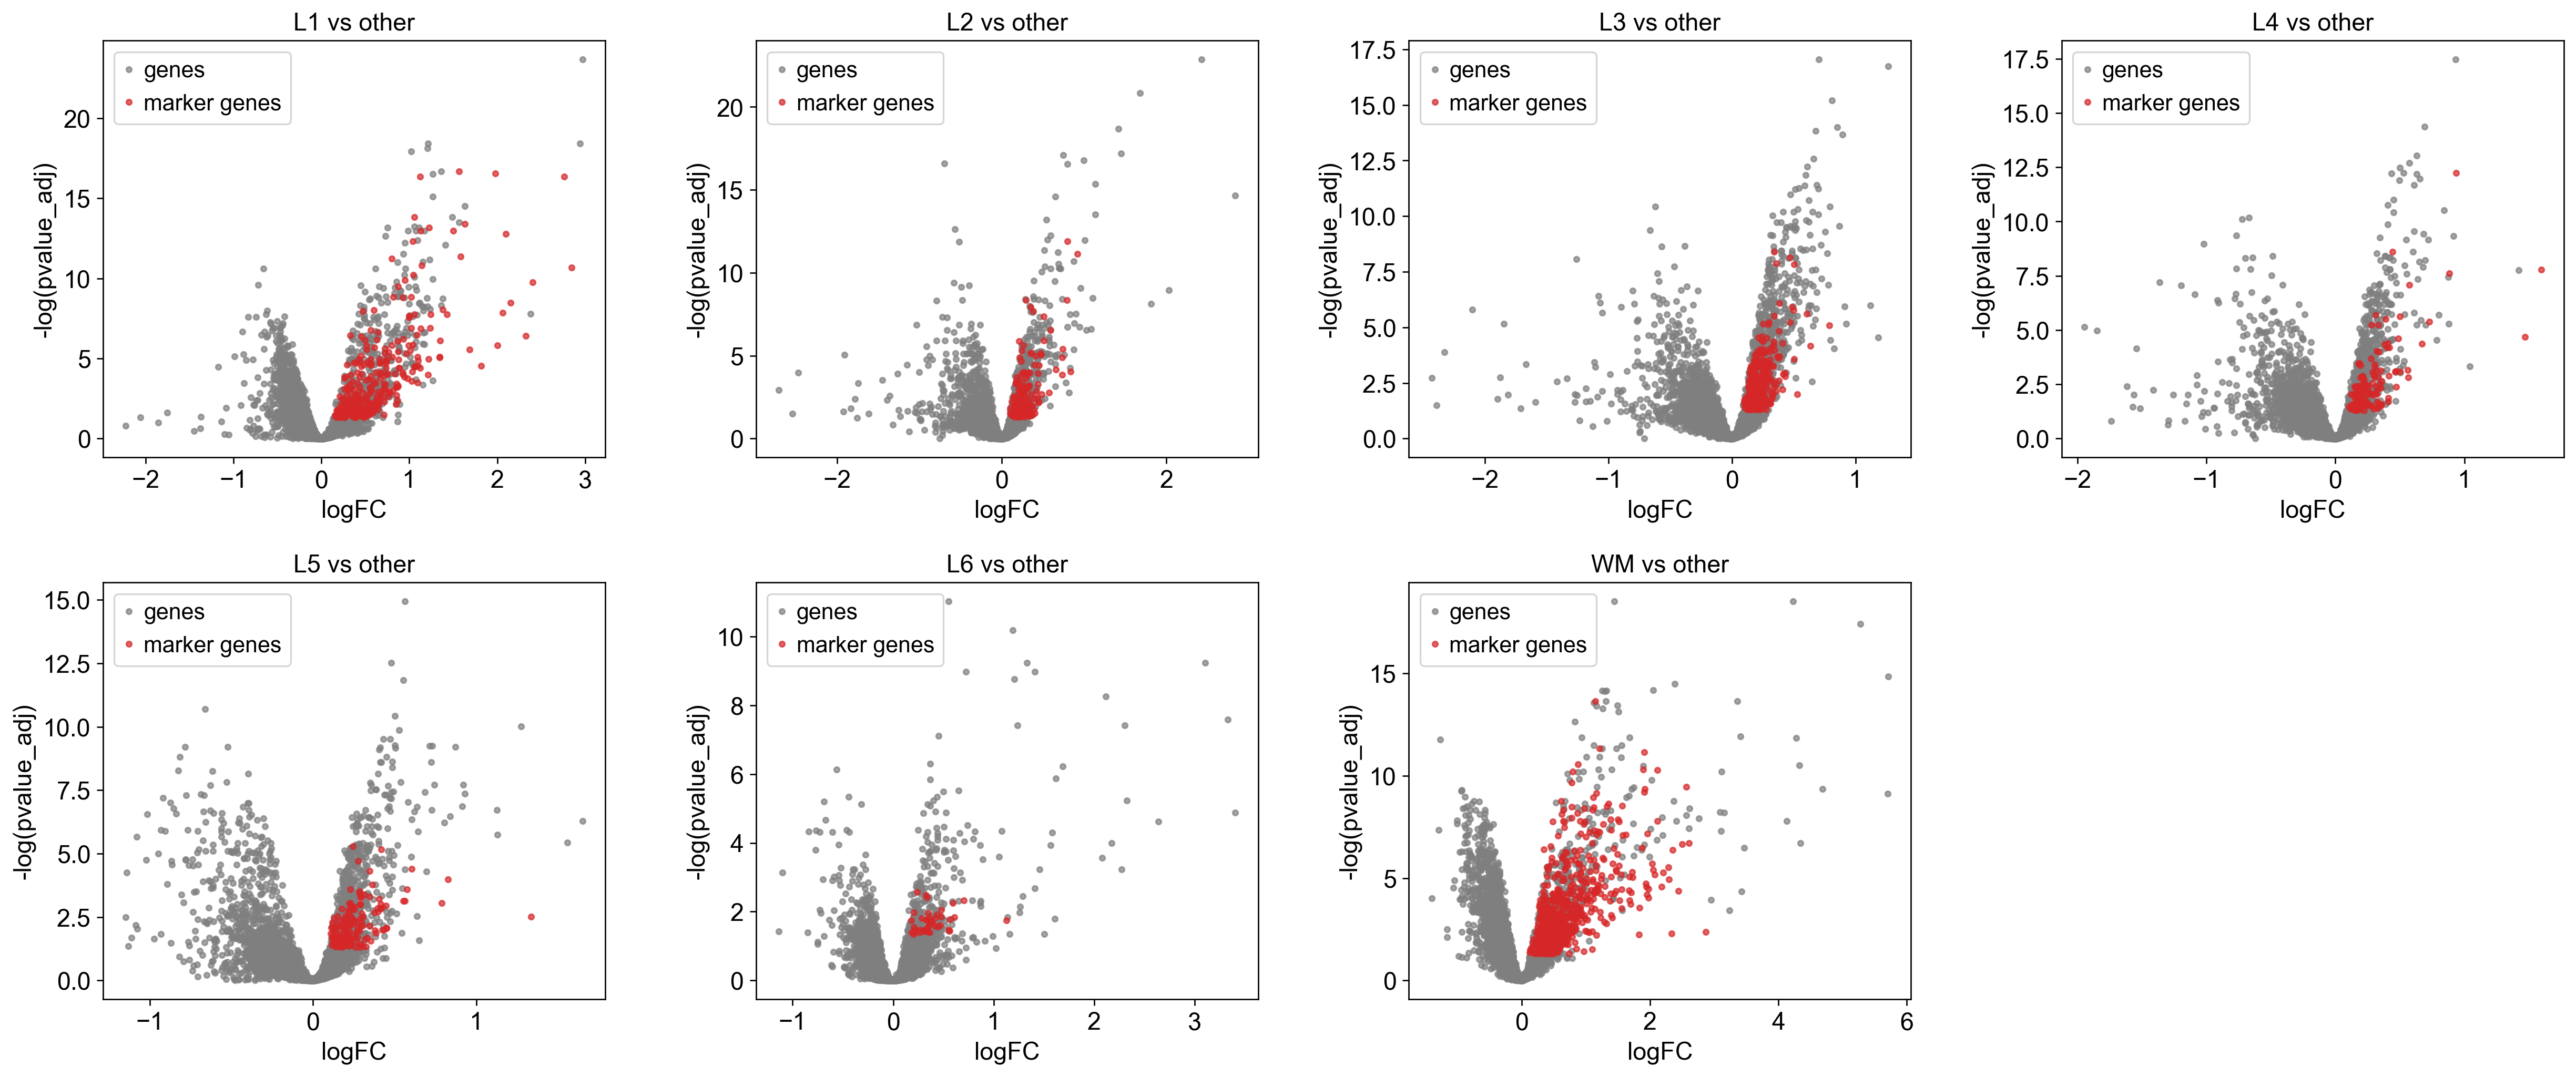

In [63]:
fig, axes = plt.subplots(2, 4,  figsize=(25, 10), gridspec_kw={'hspace': 0.3, 'wspace': 0.3}, dpi=120)
#fig, ax = plt.subplots(1, 1,  figsize=(7, 5), gridspec_kw={'hspace': 0.5})

for (layer, df), ax in zip(macaque_de.items(), axes.flatten()):
    sign_tr = ((df.p_val_adj < 0.05) & (df.logFC > 1))
    filter_cond = df.index.isin(list(unique_macaque_genes[layer]))
    ax.plot(df[~filter_cond].logFC, -np.log10(df[~filter_cond].p_val_adj), '.', c='tab:gray', alpha=0.7)
    ax.plot(df[filter_cond].logFC, -np.log10(df[filter_cond].p_val_adj), '.', c='tab:red', alpha=0.7)
    ax.grid(False)
    ax.set_title(f'{layer} vs other')
    ax.set_ylabel('-log(pvalue_adj)')
    ax.set_xlabel('logFC')
    ax.legend(['genes', 'marker genes'], loc="upper left")
fig.delaxes(axes[1, 3])

## Universal marker genes

### Common marker genes

Let's intersect marker genes for different species

In [64]:
marker_genes = dict()

for layer in layers:
    marker_genes[layer] = human_markers[layer].intersection(chimp_markers[layer]).intersection(macaque_markers[layer]).to_list()
    print(f'{layer}: {len(marker_genes[layer])} common marker genes')

L1: 244 common marker genes
L2: 47 common marker genes
L3: 113 common marker genes
L4: 99 common marker genes
L5: 95 common marker genes
L6: 32 common marker genes
WM: 14 common marker genes


Take top20 genes for each of the layers

In [65]:
top = 20
marker_top_list = []
for layer in layers:
    human_rk = human_de[layer].logFC.rank().loc[marker_genes[layer]]
    chimp_rk = chimp_de[layer].logFC.rank().loc[marker_genes[layer]]
    macaque_rk = macaque_de[layer].logFC.rank().loc[marker_genes[layer]]
    layer_topmarkers = (human_rk + chimp_rk + macaque_rk).sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

Plot the heatmap

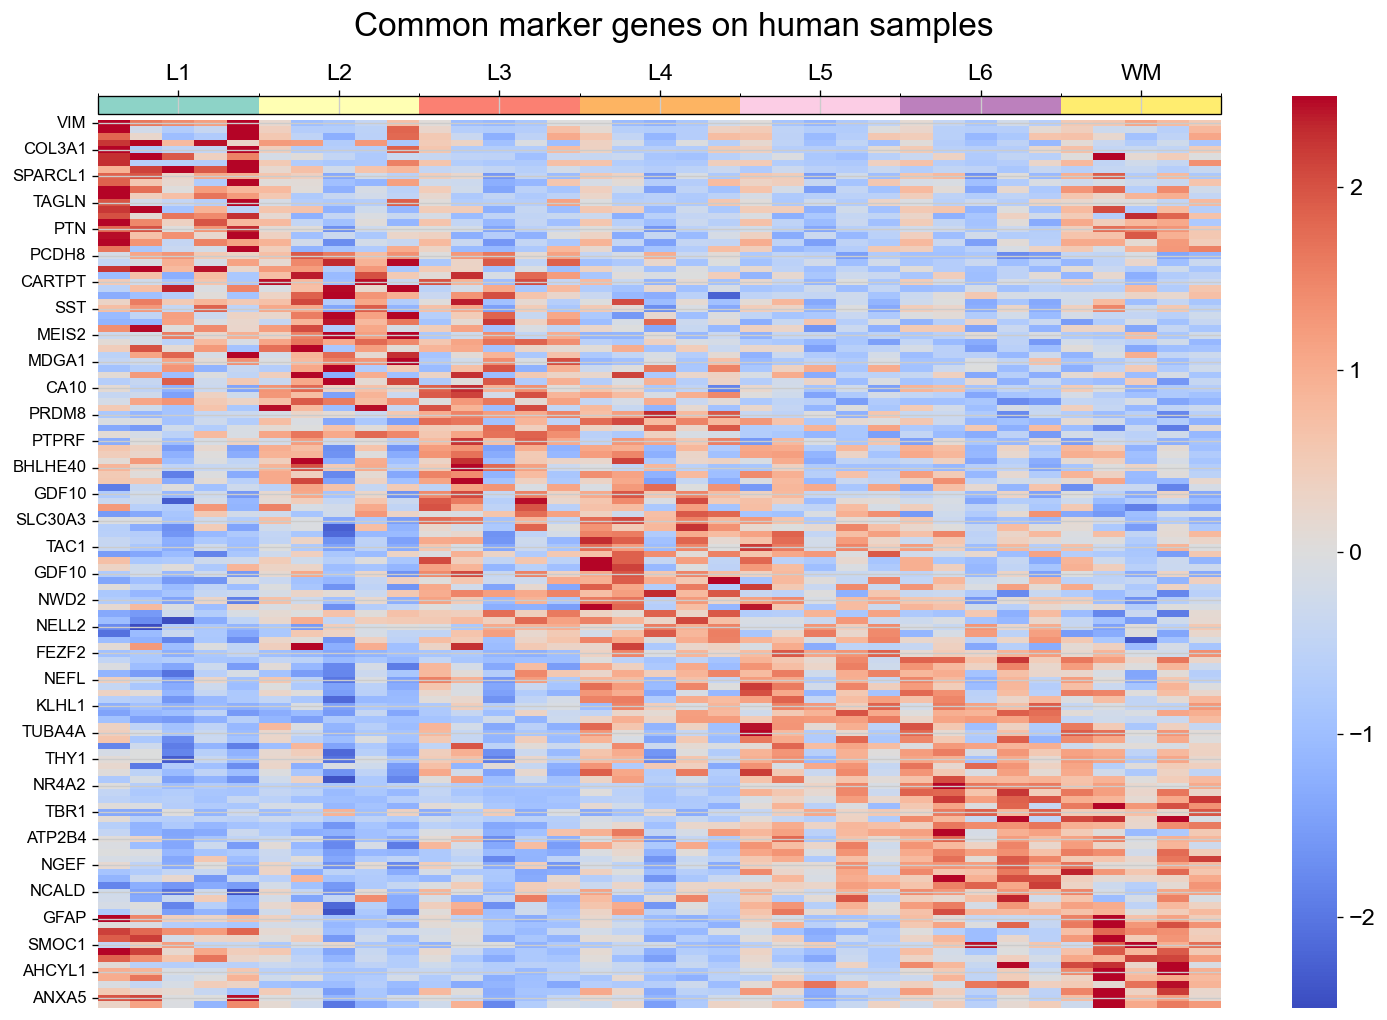

In [66]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'human', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Common marker genes on human samples', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

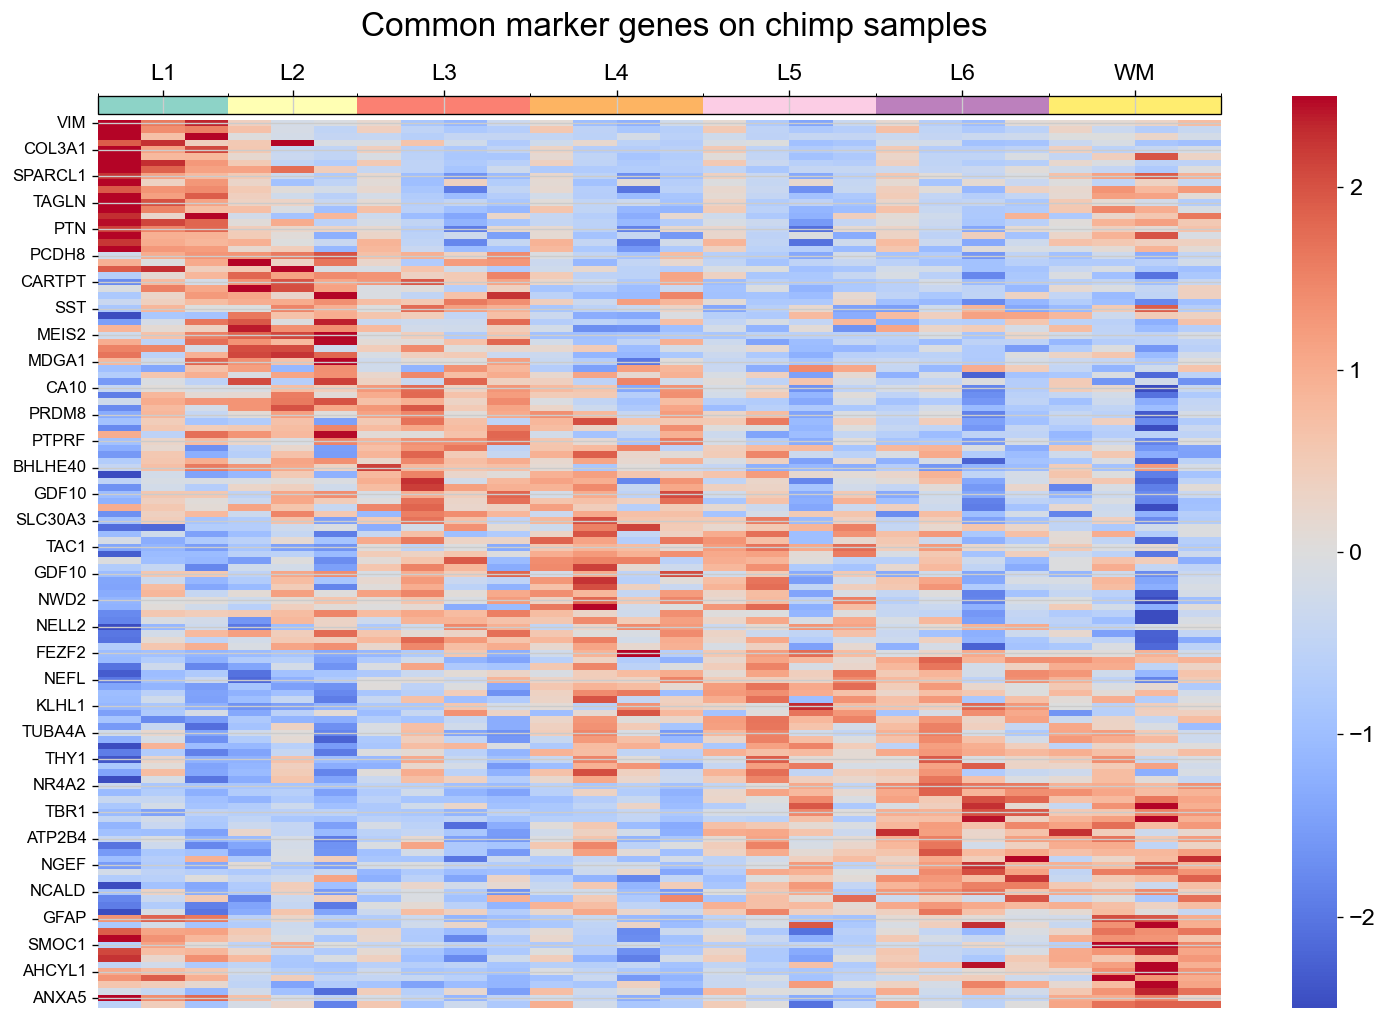

In [67]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Common marker genes on chimp samples', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

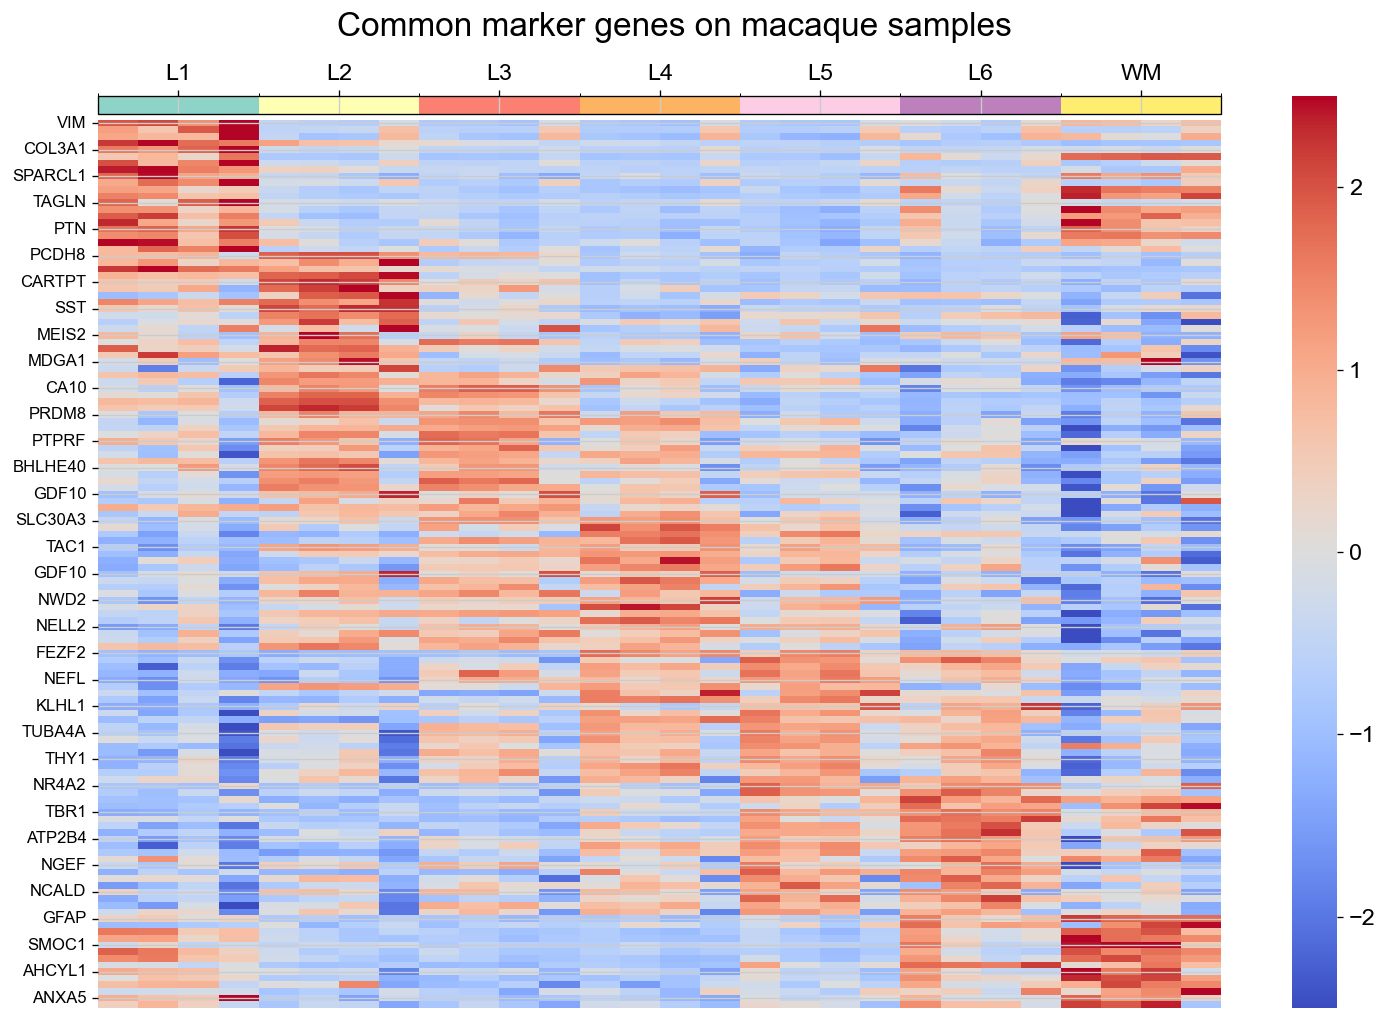

In [68]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Common marker genes on macaque samples', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

### Common unique marker genes

Let's count number of unique marker genes

In [69]:
countgene_species_df, unique_species_genes = count_unique(marker_genes)

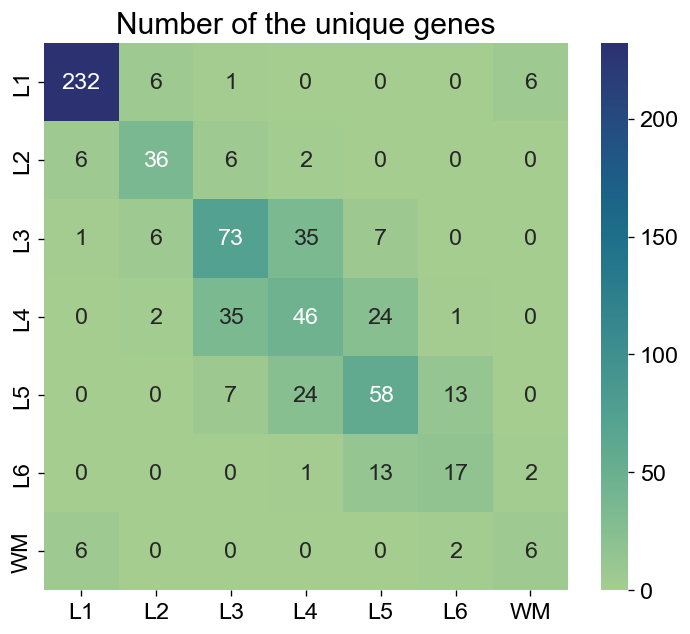

In [70]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(countgene_species_df, annot=True, cmap = 'crest', fmt=".0f")
plt.title('Number of the unique genes', fontsize=18)
plt.grid(False)

In [71]:
inter_cell_dict = inter_velm(velm_markers_dict, unique_species_genes)

In [72]:
print(inter_cell_dict)

{'AST_FB': {'L1': ['RGS20', 'RFX4', 'SLC6A1', 'ELOVL5', 'NFIC', 'TNC', 'NID1', 'CNN3'], 'L2': [], 'L3': ['SREBF2'], 'L4': ['FRMPD2'], 'L5': ['BCL11A'], 'L6': ['SEL1L3', 'NR4A2'], 'WM': ['SMOC1']}, 'L2_3': {'L1': ['CNTNAP4'], 'L2': ['MDGA1', 'MEIS2', 'PRSS12'], 'L3': ['FGF13'], 'L4': [], 'L5': ['RALYL', 'KLHL1', 'LGI1'], 'L6': [], 'WM': []}, 'L4': {'L1': ['RPL3'], 'L2': [], 'L3': ['EEF1A2', 'UCHL1'], 'L4': ['CFL1'], 'L5': ['LGI1'], 'L6': [], 'WM': []}, 'L5': {'L1': [], 'L2': ['CYP26A1', 'PHPT1'], 'L3': ['EEF1A2', 'LMO4', 'VSTM2L'], 'L4': ['KCNAB1'], 'L5': [], 'L6': ['NGEF', 'NR4A2'], 'WM': []}, 'L5_6_IT': {'L1': ['SGK1'], 'L2': ['MDGA1', 'MEIS2', 'PRSS12'], 'L3': [], 'L4': ['GFRA2'], 'L5': [], 'L6': [], 'WM': []}, 'L6': {'L1': [], 'L2': [], 'L3': ['FGF13', 'LMO4', 'VSTM2L'], 'L4': ['NPDC1'], 'L5': [], 'L6': ['NR4A2'], 'WM': []}}


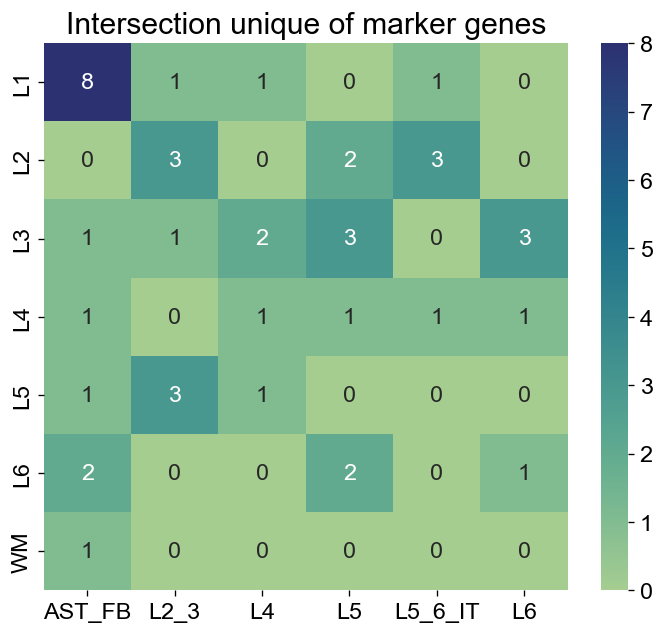

In [73]:
plt.figure(figsize=(7, 6), dpi=60)
sns.heatmap(pd.DataFrame(inter_cell_dict).applymap(len), annot=True, cmap = 'crest', fmt=".0f")
plt.title('Intersection unique of marker genes', fontsize=18)
plt.grid(False)

Take top20 genes for each of the layers

In [74]:
marker_top_list[:20]

['VIM',
 'COL1A1',
 'PTGDS',
 'CXCL14',
 'COL3A1',
 'ID3',
 'ACTA2',
 'NR2F2',
 'SPARCL1',
 'DCN',
 'AQP4',
 'DAAM2',
 'TAGLN',
 'S100B',
 'TNC',
 'METRN',
 'PTN',
 'B2M',
 'ATP1A2',
 'FN1']

In [75]:
top = 20
marker_top_list = []
for layer in layers:
    slice_top = min(top, len(unique_species_genes[layer]))
    human_rk = human_de[layer].logFC.rank().loc[list(unique_species_genes[layer])]
    chimp_rk = chimp_de[layer].logFC.rank().loc[list(unique_species_genes[layer])]
    macaque_rk = macaque_de[layer].logFC.rank().loc[list(unique_species_genes[layer])]
    layer_topmarkers = (human_rk + chimp_rk + macaque_rk).sort_values(ascending=False).index.to_list()[:top]
    marker_top_list.append(layer_topmarkers)

marker_top_list = list(itertools.chain(*marker_top_list))

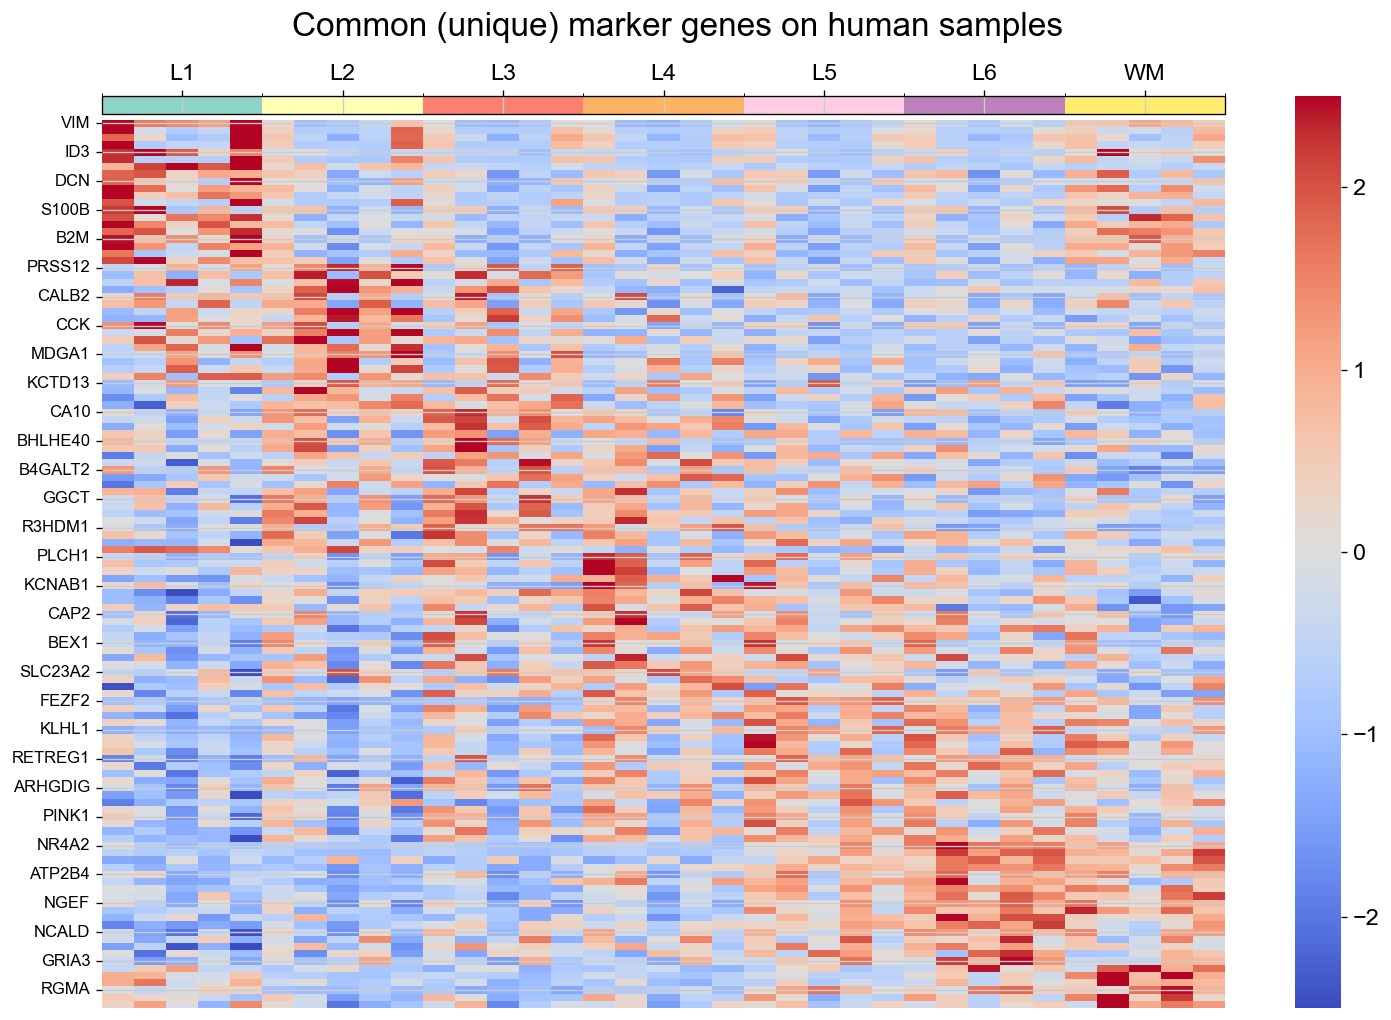

In [76]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'human', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Common (unique) marker genes on human samples', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

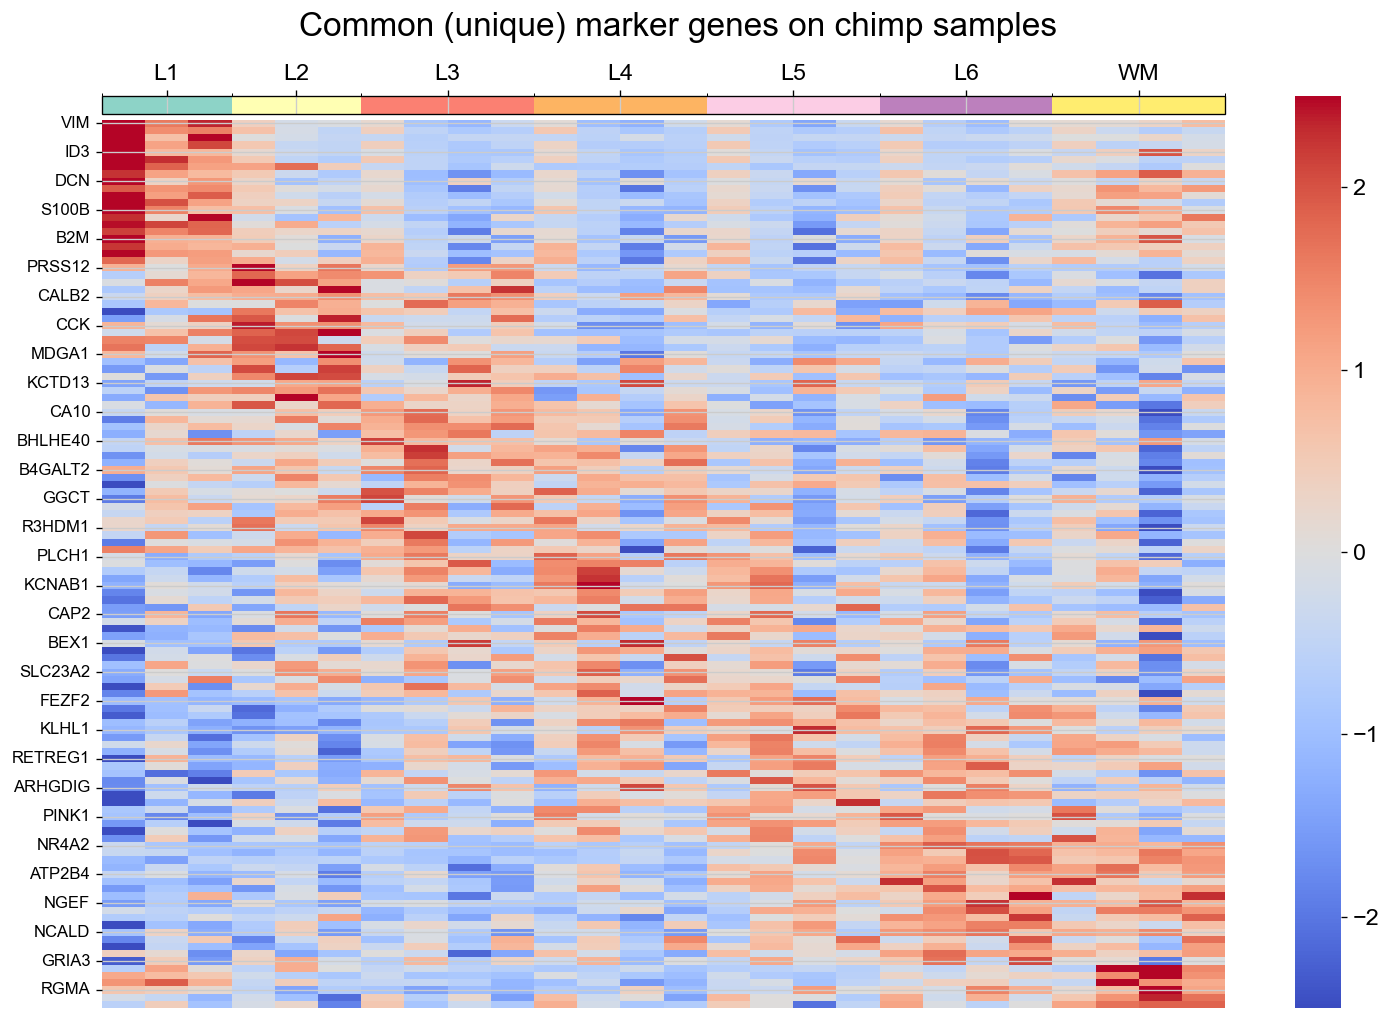

In [77]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'chimp', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Common (unique) marker genes on chimp samples', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()

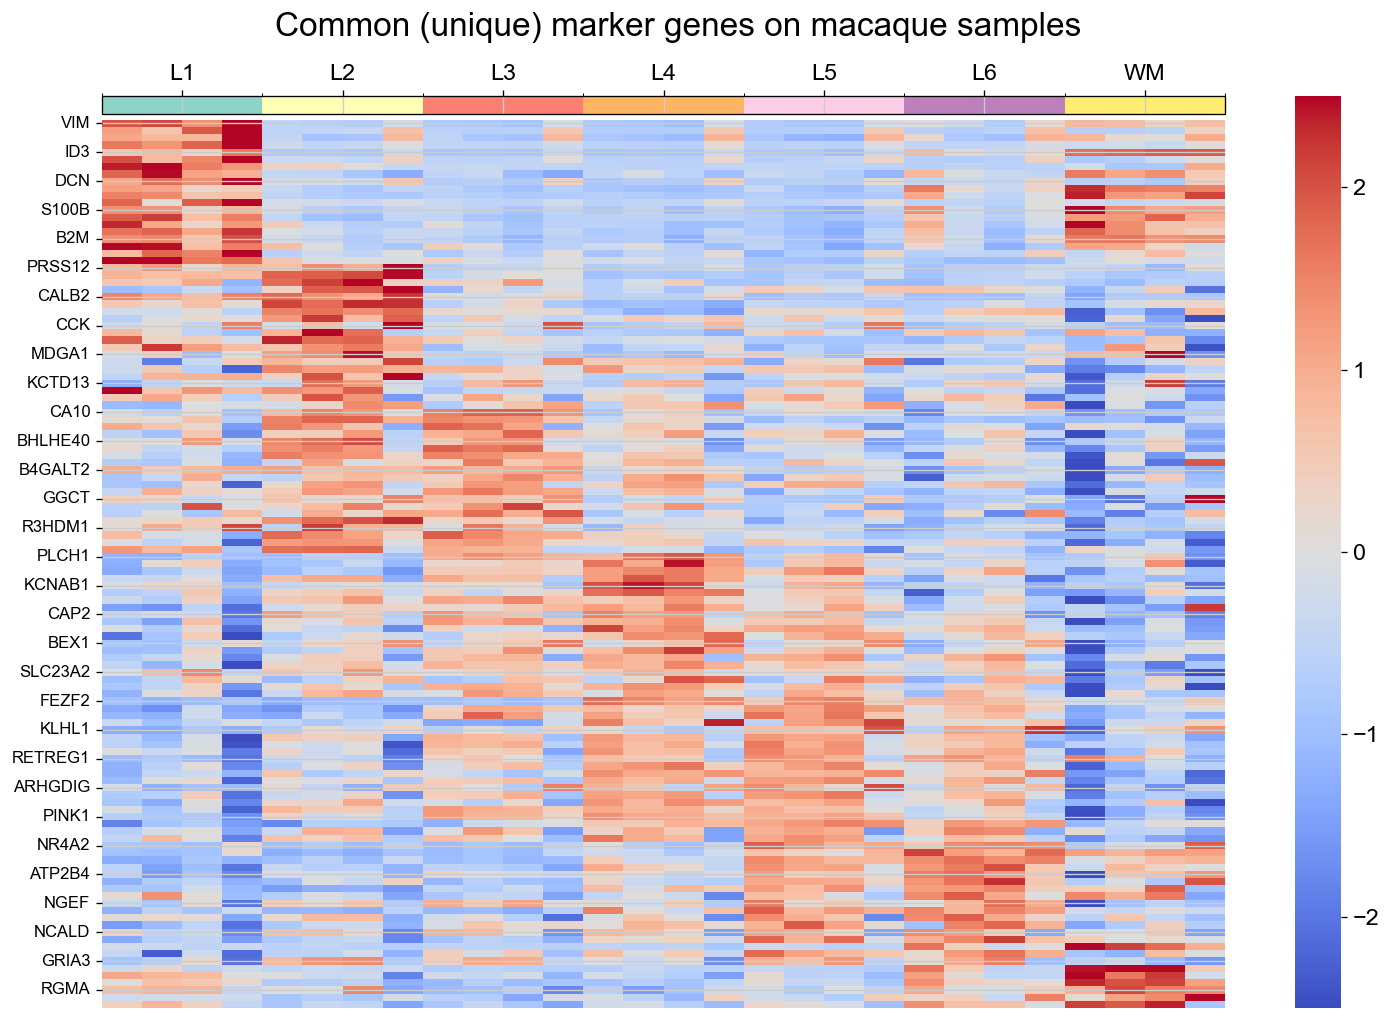

In [78]:
from scipy.stats import zscore
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(15, 10), dpi=60)
adata_subs = adata_pb[adata_pb.obs.condition == 'macaque', marker_top_list]
expr_df = pd.DataFrame(adata_subs.X, index=adata_subs.obs_names, columns=marker_top_list).apply(zscore)
sns.heatmap(expr_df.T, cmap='coolwarm', center=0, vmin=-2.5, vmax=2.5, ax=ax, xticklabels=False)
ax.tick_params(axis='both', which='major', labelsize=10)
fig.suptitle('Common (unique) marker genes on macaque samples', fontsize=20)

divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

layer_size = adata_subs.obs.layer.value_counts().loc[layers].values
layer_pos = layer_size.cumsum()
bounds = [0] + list(layer_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(layer_pos - layer_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
cax.xaxis.tick_top()